# Natural Language Processing: Tweet Sentiment Analysis

**Author**: Albane Colmenares <br>
**Date**: December 12th, 2023 <br>
___________________________________________________________________________

### Table of Content
**1. [Overview](#overview)**<br>
**2. [Business Understanding](#business_understanding)**<br>
**3. [Data Understanding](#data_understanding)**<br>
**4. [Data Preparation](#data_preparation)**<br>
**5. [Modeling](#modeling)**<br>
**6. [Evaluation](#evaluation)**<br>
**7. [Findings & Recommendations](#findings_n_recommendations)**<br>
**8. [Limits & Next Steps](#limits_n_next_steps)**<br>

overview
<a id='overview'></a>

## 1. Overview

This notebook examines tweets about Google and Apple products and predicts whether the sentiment of unseen tweets is positive or negative. <br>
The organization of this notebook follows the CRoss Industry Standard Process for Data Mining (CRISP-DM) is a process model that serves as the base for a data science process.

business_understanding
<a id='business_understanding'></a>

## 2. Business Understanding

We, as the agency entrusted by Samsung, have been tasked with shaping the marketing strategy for the imminent <u>launch</u> of their cutting-edge <u>folding tablet</u>. 
<br>Due to the unique nature of the product, substantial funds were allocated for research and development. Consequently, there is a constraint on budget for the launch phase. 
<br>Nevertheless, Samsung aims to generate significant buzz around this groundbreaking product, confident that its innovation will speak for itself. 


In our initial conversations, it was recommened that the product be unveiled at South by Southwest, a major conference in the industry. The event has an `Interactive` division, which focuses on new technology where speakers, parties and trade shows are hosted. 

The objective of this project has two main aspects: 
1. Analyze the success stories of the two technology leaders in the industry at South by Southwest 
    * Identify factors that were received positively to understand dynamics of a successful launch - and not positive responses to know what to avoid
2. Predict the tweets' sentiment 
    * Every strategy needs to measure the Return On Investment. Predicting tweet sentiment will provide a quantifiable metric to evaluate the efficacy of the deployed strategy.
    
    
The target audience is Samsung marketing strategy teams.


data_understanding
<a id='data_understanding'></a>

## 3. Data Understanding

* **Data Source**

The data comes from CrowdFlower via [data.world](https://data.world/crowdflower/brands-and-product-emotions). 

Tweets about the two leading technology brands and products were grouped into the dataset. The tweets were categorized by the sentiment that was expressed: positive, negative or neutral. The product or brand referenced by the short text is also indicated when known. 

The file `judge-1377884607_tweet_product_company.csv` can be downloaded at the provided link. 
It was then renamed to `tweet_product_company.csv`and saved into the current folder, within the 'data' subfolder, to be accessed into the raw DataFrame. 


* **Features**

Prior to preprocessing, the columns are: 

* `tweet_text`: the actual tweet's record
* `emotion_in_tweet_is_directed_at`: the product or company referred to in the tweet
* `is_there_an_emotion_directed_at_a_brand_or_product`: the tweet's sentiment

* **Target**

The tweet's sentiment is the target for the dataset. The specific column is `is_there_an_emotion_directed_at_a_brand_or_product`. Based on a given set of tweets, we will try to predict if the tweet's emotion was positive, negative or neutral. 

* **Loading the data**

In [1]:
# Importing the necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
import nltk

%matplotlib inline

The text file is encoded using Latin-1 encoding - and is open as is. Several encodings were tried to ensure the right one matched: utf-8, utf-16, ascii for example.

In [2]:
# Loading dataset and saving it as raw_df
raw_df = pd.read_csv('data/tweet_product_company.csv', encoding='latin-1')

In [3]:
# Inspecting the first 5 rows of the DataFrame
raw_df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [4]:
print(f'The dataset has '+ str(len(raw_df)) + ' rows and 3 columns.' )

The dataset has 9093 rows and 3 columns.


The various companies and products referred to in the tweets will be reviewed to get an understand of the balance in the dataset, along with what is being most often reviewed.  

Similarly, the emotions will be reviewed in a similar way. 

In [5]:
# Inspecting the number of tweets referring to each product or company
raw_df['emotion_in_tweet_is_directed_at'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [6]:
# Inspecting the number of tweets referring to each emotion
raw_df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

data_preparation
<a id='data_preparation'></a>

## 4. Data Preparation

## 4: 1- <u>Data Cleaning</u>

For a better readability of the tweets' texts, the column width will be increased. In addition, the use of MathJax will be disabled so that the visual representation of mathematical expressions are not displayed so this doesn't cause issues to the environment. 

In [7]:
# Increasing column width
pd.set_option('max_colwidth', 400)
pd.set_option('use_mathjax', False)

### 4. a) Column names' change

The column names are particularly long. For an easier process to handle, they will be renamed in the new DataFrame called `df`:
* `tweet`
* `product_or_company`
* `sentiment`


In [8]:
# Making a copy of the raw DataFrame to modify it
df = raw_df.copy()

In [9]:
# Defining the new columns' names and attributing them to the new DataFrame
df.columns = ['tweet', 'product_or_company', 'sentiment']

In [10]:
# Verifying the changes applied  
df.head()

,tweet,product_or_company,sentiment
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative emotion
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative emotion
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive emotion


### 4. c) Missing data

In the next section, the missing values are inspected and handled by category. 
<br>
The `tweet` column only had 1 row with null values and had no implication on other features: it is removed. 
<br>
The `product_or_company` requires contains many more missing values. 

In [11]:
# Looking for missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet               9092 non-null   object
 1   product_or_company  3291 non-null   object
 2   sentiment           9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


* **Tweet**

The tweet column only has one null value with no information on the other columns: it will be dropped from the DataFrame.  

In [12]:
# Inspecting the tweet containing null information 
df[df['tweet'].isnull()]

,tweet,product_or_company,sentiment
6,NaN,NaN,No emotion toward brand or product


The null tweet does not contain any information for either column and will be dropped.  

In [13]:
# Dropping the null tweet from the DataFrame

df = df.dropna(subset=['tweet'])

In [14]:
# Verifying it was correctly removed
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9092 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet               9092 non-null   object
 1   product_or_company  3291 non-null   object
 2   sentiment           9092 non-null   object
dtypes: object(3)
memory usage: 284.1+ KB


In [15]:
print(f'The dataset now has '+ str(len(df)) + '. The missing tweet was removed.' )

The dataset now has 9092. The missing tweet was removed.


* **Product or Company**

The product_or_company column contains many null values where neither the product or the brand was specified. For now, all null values will be replaced by 'unknown', as the focus is to predict sentiment. 
<br>If the focus on product or company needs to be done, two columns will be created to identify the product and the brand. 

In [16]:
# Inspecting the tweet containing null information 
df[df['product_or_company'].isnull()]

,tweet,product_or_company,sentiment
5,@teachntech00 New iPad Apps For #SpeechTherapy And Communication Are Showcased At The #SXSW Conference http://ht.ly/49n4M #iear #edchat #asd,NaN,No emotion toward brand or product
16,Holler Gram for iPad on the iTunes App Store - http://t.co/kfN3f5Q (via @marc_is_ken) #sxsw,NaN,No emotion toward brand or product
32,"Attn: All #SXSW frineds, @mention Register for #GDGTLive and see Cobra iRadar for Android. {link}",NaN,No emotion toward brand or product
33,Anyone at #sxsw want to sell their old iPad?,NaN,No emotion toward brand or product
34,Anyone at #SXSW who bought the new iPad want to sell their older iPad to me?,NaN,No emotion toward brand or product
...,...,...,...
9087,"@mention Yup, but I don't have a third app yet. I'm on Android, any suggestions? #SXSW CC: @mention",NaN,No emotion toward brand or product
9089,"Wave, buzz... RT @mention We interrupt your regularly scheduled #sxsw geek programming with big news {link} #google #circles",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported potential AE. Yet FDA relies on physicians. &quot;We're operating w/out data.&quot; #sxsw #health2dev",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their time fell back an hour this weekend. Of course they were the New Yorkers who attended #SXSW.,NaN,No emotion toward brand or product


In [17]:
# Replacing the null product or company with 'undefined'
df['product_or_company'] = df['product_or_company'].fillna('undefined')

In [18]:
# Verifying it was correctly handled
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9092 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet               9092 non-null   object
 1   product_or_company  9092 non-null   object
 2   sentiment           9092 non-null   object
dtypes: object(3)
memory usage: 284.1+ KB


In [19]:
print(f'The dataset still has '+ str(len(df)) + '.' )

The dataset still has 9092.


In [20]:
# Verifying the count of rows by unique value in this column
df['product_or_company'].value_counts()

undefined                          5801
iPad                                946
Apple                               661
iPad or iPhone App                  470
Google                              430
iPhone                              297
Other Google product or service     293
Android App                          81
Android                              78
Other Apple product or service       35
Name: product_or_company, dtype: int64

In [21]:
# Verifying the count of rows by unique value in this column
df['product_or_company'].value_counts(normalize=True)

undefined                          0.638033
iPad                               0.104048
Apple                              0.072701
iPad or iPhone App                 0.051694
Google                             0.047294
iPhone                             0.032666
Other Google product or service    0.032226
Android App                        0.008909
Android                            0.008579
Other Apple product or service     0.003850
Name: product_or_company, dtype: float64

### 4. d) Handling duplicates

In [22]:
# How many rows were duplicates
print(str(len(df[df.duplicated()])) + f' duplicate rows were identified.')

22 duplicate rows were identified.


In [23]:
# Viewing the duplicate rows
df[df.duplicated()]

,tweet,product_or_company,sentiment
468,"Before It Even Begins, Apple Wins #SXSW {link}",Apple,Positive emotion
776,"Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw",undefined,No emotion toward brand or product
2232,Marissa Mayer: Google Will Connect the Digital &amp; Physical Worlds Through Mobile - {link} #sxsw,undefined,No emotion toward brand or product
2559,Counting down the days to #sxsw plus strong Canadian dollar means stock up on Apple gear,Apple,Positive emotion
3950,Really enjoying the changes in Gowalla 3.0 for Android! Looking forward to seeing what else they &amp; Foursquare have up their sleeves at #SXSW,Android App,Positive emotion
3962,"#SXSW is just starting, #CTIA is around the corner and #googleio is only a hop skip and a jump from there, good time to be an #android fan",Android,Positive emotion
4897,"Oh. My. God. The #SXSW app for iPad is pure, unadulterated awesome. It's easier to browse events on iPad than on the website!!!",iPad or iPhone App,Positive emotion
5338,RT @mention ÷¼ GO BEYOND BORDERS! ÷_ {link} ã_ #edchat #musedchat #sxsw #sxswi #classical #newTwitter,undefined,No emotion toward brand or product
5341,"RT @mention ÷¼ Happy Woman's Day! Make love, not fuss! ÷_ {link} ã_ #edchat #musedchat #sxsw #sxswi #classical #newTwitter",undefined,No emotion toward brand or product
5881,"RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw",undefined,No emotion toward brand or product


In [24]:
# Verifying with one example that tweets were indeed duplicated 
df[df['tweet'] == 'Before It Even Begins, Apple Wins #SXSW {link}']

,tweet,product_or_company,sentiment
466,"Before It Even Begins, Apple Wins #SXSW {link}",Apple,Positive emotion
468,"Before It Even Begins, Apple Wins #SXSW {link}",Apple,Positive emotion


In [25]:
# Dropping duplicates
df.drop_duplicates(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9070 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet               9070 non-null   object
 1   product_or_company  9070 non-null   object
 2   sentiment           9070 non-null   object
dtypes: object(3)
memory usage: 283.4+ KB


### 4. d) Turning sentiment classification into a binary one

* **Product or Company**

The product or company column does not have an impact on whether a tweet is positive or negative, so it will not be transformed as it will not be used further for predictions. 

* **Sentiment**

Four sentiment categories are described, which could be grouped in two: positive and not positive. 
<br>This is what will be covered over the next section. 

In [26]:
# Number of rows by emotion
df['sentiment'].value_counts()

No emotion toward brand or product    5375
Positive emotion                      2970
Negative emotion                       569
I can't tell                           156
Name: sentiment, dtype: int64

* **Categorizing**

Due to the nature of the target, we will focus on the positive ones. Hence all the other tweets, whether they are neutral or negative, will be considered ***not positive***. For easier reference, it will be identified as ***negative***.

In [27]:
# Defining the new classifications for the sentiment column 
classification_columns = {
    'sentiment': {
        "No emotion toward brand or product": "negative", 
        "I can't tell": "negative", 
        "Positive emotion": "positive", 
        "Negative emotion": "negative" 
    }
}

In [28]:
# Converting the sentiment column classification

# Defining columns to change
column_classification = ['sentiment']

def convert_class(df, columns_mapping):
    for column, mapping in columns_mapping.items():
        print('Before: ' + column, df[column].unique())
        df[column] = df[column].map(mapping)
        print('After: ' + column, df[column].unique())
    

In [29]:
# Calling the function to convert the classification into a binary one
convert_class(df, classification_columns)

Before: sentiment ['Negative emotion' 'Positive emotion'
 'No emotion toward brand or product' "I can't tell"]
After: sentiment ['negative' 'positive']


In [30]:
# Rewiewing the new categorization of rows by unique sentiment
df['sentiment'].value_counts()

negative    6100
positive    2970
Name: sentiment, dtype: int64

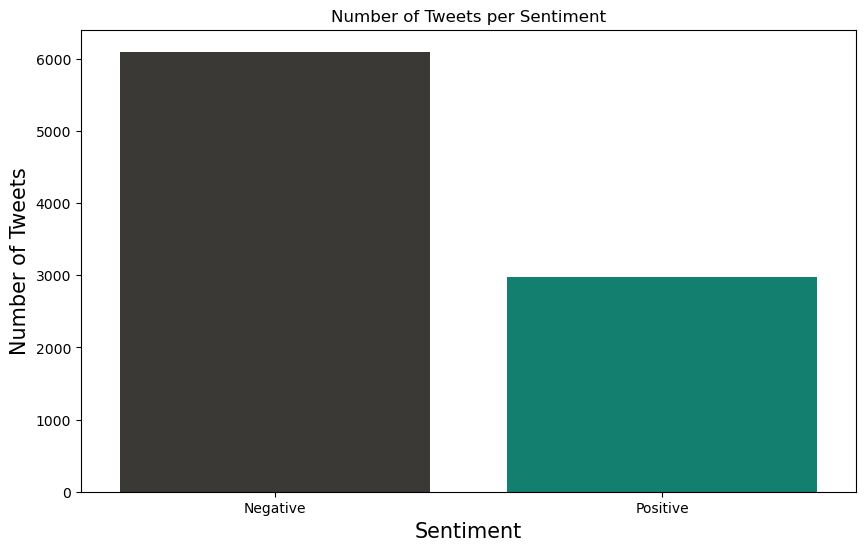

In [31]:
# Creating a bar chart for to visualize class imbalance
fig, ax = plt.subplots(figsize=(10,6))

# Defining custom colors 
custom_colors = ['#3B3935', '#00917C']

sns.countplot(data=df, x='sentiment', order=df['sentiment'].value_counts().index, palette=custom_colors)

ax.set_xlabel(xlabel = 'Sentiment', fontsize=15)
ax.set_ylabel(ylabel = 'Number of Tweets', fontsize=15)

ax.set_xticklabels(labels=['Negative', 'Positive'])

ax.set_title(f'Number of Tweets per Sentiment')

 # Saving the plot as a PNG with a transparent background
plt.savefig('images/tweets_per_sentiment.png', transparent=True)

plt.show()

### 4. e) Performing a Train-Test Split

In [32]:
# Splitting df into X and y
X = df.drop('sentiment', axis=1)
y = df['sentiment']

In [33]:
# Performing a train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [34]:
# Inspecting the X_train data
X_train.head()

,tweet,product_or_company
8268,Huge shout out to GSDM &amp; Google for the kick ass party tonight! We had an unbelievable time. #SXSW,Google
945,#SXSW 20% of Google searches are for local information: Marissa Mayer. 6 million places claimed by their owners and logged by #Google,undefined
8832,free #sxsw playlist.. enjoy {link},undefined
7771,Awesome! RT @mention Yes! Gowalla wins best Andoid app at the Team Android Choice Awards. Thanks all! #sxsw,Android App
1643,#justmet @mention who worked for Apple for 25 years! #SXSW,Apple


In [35]:
# Inspecting the y_train data 
y_train.head()

8268    positive
945     negative
8832    negative
7771    positive
1643    positive
Name: sentiment, dtype: object

* **Distribution of Target**

In [36]:
# Creating a dataframe counting the values of sentiment categories   
train_target_counts = pd.DataFrame(y_train.value_counts())
train_target_counts.index.name = 'target name'
train_target_counts.rename(columns={'sentiment': 'count'}, inplace=True)

# Inspecting the grouped results
train_target_counts

,count
target name,
negative,4575
positive,2227


* **Visually Inspecting Features**

In [37]:
# Making a sample of 5 records to display the full text of each
train_sample = X_train.sample(5, random_state=22)
train_sample['label'] = [y_train[val] for val in train_sample.index]
train_sample.style.set_properties(**{'text-align': 'left'})

,tweet,product_or_company,label
3586,Dang it. I've touched an iPad 2. I WANT! *sigh* #SXSW,iPad,positive
3901,Has made it into the press room got the swag and registered for an iPad 2. Hopefully get to meet mike tyson and @mention #sxsw,undefined,negative
133,"#Samsung, #Sony follow #Apple, #HP lead @mention {link} #Austin #atx #SXSW",undefined,negative
7937,UberGenius: Uber Is Taking Control of SXSW Pedicabs {link} #iPhone #LIVESTRONG #NewYorkCity #SanFrancisco #SXSW,undefined,negative
85,Stay tune @mention showcase #H4ckers {link} #SXSW,undefined,negative


## 4: 2- <u>Data Preprocessing & Exploratory Analysis</u>

In order to preprocess the tweets, the following transformations were performed: 
* <u>Standardizing case</u>
    <br>This step is important to ensure text is uniform and consistent. This prevents models from treating words with different cases as different ones
    
* <u>Tokenizing</u>
    <br>Tokens of one or two consecutive words were created. This was done with the `RegexpTokenizer` package from nltk.tokenize <br>
* <u>Stopwords</u> 
    <br>To focus on the data's theme, English stopwords were removed. Manual additions were made in this text's context (i.e. "sxsw", "mention")  
* <u>Lemmatize</u> 
    <br> The `WordNetLemmatizer` package from nltk.stem.wordnet was used to reduce words to their base form, allowing a more accurate analysis
* <u>Frequency Distribution</u>
    <br>The `FreqDist` package was used to review in a dictionary-like output, the words and their frequencies
* <u>WordCloud</u>
    <br> The words' frequencies were represented visually thanks to the `WordCloud` package
* <u>Bigrams</u>
    <br> Bigrams were drawn to have a better understanding of the themes, i.e. pop was identified with pop-up store, thanks to the `collocations` package and its BigramAssocMeasures
* <u>Mutual Information Scores</u>
    <br> Bigrams that occur more than 5 times were examined through `mutual information scores`

Before any transformation is done, a copy of the tweet column will be done. 

In [38]:
# Duplicating the column tweet
X_train['tweet_original'] = X_train['tweet']

In [39]:
# Verifying the new column was correctly created
X_train.head()

,tweet,product_or_company,tweet_original
8268,Huge shout out to GSDM &amp; Google for the kick ass party tonight! We had an unbelievable time. #SXSW,Google,Huge shout out to GSDM &amp; Google for the kick ass party tonight! We had an unbelievable time. #SXSW
945,#SXSW 20% of Google searches are for local information: Marissa Mayer. 6 million places claimed by their owners and logged by #Google,undefined,#SXSW 20% of Google searches are for local information: Marissa Mayer. 6 million places claimed by their owners and logged by #Google
8832,free #sxsw playlist.. enjoy {link},undefined,free #sxsw playlist.. enjoy {link}
7771,Awesome! RT @mention Yes! Gowalla wins best Andoid app at the Team Android Choice Awards. Thanks all! #sxsw,Android App,Awesome! RT @mention Yes! Gowalla wins best Andoid app at the Team Android Choice Awards. Thanks all! #sxsw
1643,#justmet @mention who worked for Apple for 25 years! #SXSW,Apple,#justmet @mention who worked for Apple for 25 years! #SXSW


### 4: 2- a) Standardizing Case

Before starting any exploratory analysis, two fundamental data cleaning tasks will be performed on the text data: standardizing case and tokenizing. The first one will be standardizing.

We will glance at the first sample of tweet to get an idea of whether we need to standardize case.  

In [40]:
# Isolating the first tweet into windows_sample
tweet_sample = train_sample.iloc[0]["tweet"]
tweet_sample

"Dang it. I've touched an iPad 2. I WANT!  *sigh* #SXSW"

* **Lower case**

Changing to lower case is necessary. We will apply this to the first tweet sample. 

In [41]:
# Transforming sample data to lowercase
tweet_sample.lower()

"dang it. i've touched an ipad 2. i want!  *sigh* #sxsw"

This answers our needs - we will apply this to our sample

In [42]:
# Transforming sample data to lowercase
train_sample['tweet'] = train_sample['tweet'].str.lower()
# Displaying full text
train_sample.style.set_properties(**{'text-align': 'left'})

,tweet,product_or_company,label
3586,dang it. i've touched an ipad 2. i want! *sigh* #sxsw,iPad,positive
3901,has made it into the press room got the swag and registered for an ipad 2. hopefully get to meet mike tyson and @mention #sxsw,undefined,negative
133,"#samsung, #sony follow #apple, #hp lead @mention {link} #austin #atx #sxsw",undefined,negative
7937,ubergenius: uber is taking control of sxsw pedicabs {link} #iphone #livestrong #newyorkcity #sanfrancisco #sxsw,undefined,negative
85,stay tune @mention showcase #h4ckers {link} #sxsw,undefined,negative


This answers our needs - we will apply this to our full dataset

### 4: 2- b) Tokenizing

The second fundamental data cleaning step is to tokenize the text data.

In [43]:
# Reviewing one of our train_sample tweets
tweet_sample

"Dang it. I've touched an iPad 2. I WANT!  *sigh* #SXSW"

We will use `RegexpTokenizer` from NLTK to create tokens of tow or more consecutive word characters, which include letters, numbers and underscores.

* **Tokenizing Pattern**

In [44]:
# Importing RegexpTokenizer
from nltk.tokenize import RegexpTokenizer

basic_token_pattern = r"(?u)\b\w\w+\b"


tokenizer = RegexpTokenizer(basic_token_pattern)
tweet_tokenized = tokenizer.tokenize(tweet_sample)
tweet_tokenized

['Dang', 'it', 've', 'touched', 'an', 'iPad', 'WANT', 'sigh', 'SXSW']

We will now apply it to our full sample

In [45]:
train_sample['tweet'] = train_sample['tweet'].apply(lambda x: tokenizer.tokenize(x))

In [46]:
train_sample['tweet']

3586                                                                                                   [dang, it, ve, touched, an, ipad, want, sigh, sxsw]
3901    [has, made, it, into, the, press, room, got, the, swag, and, registered, for, an, ipad, hopefully, get, to, meet, mike, tyson, and, mention, sxsw]
133                                                                             [samsung, sony, follow, apple, hp, lead, mention, link, austin, atx, sxsw]
7937                                [ubergenius, uber, is, taking, control, of, sxsw, pedicabs, link, iphone, livestrong, newyorkcity, sanfrancisco, sxsw]
85                                                                                                    [stay, tune, mention, showcase, h4ckers, link, sxsw]
Name: tweet, dtype: object

### 4: 2- c) Stopwords

Then, removing stopwords so we can focus on the the text data's theme.

Typical list of stopwords to which we will add:
* `sxsw`: the name of the conference 
* `mention`: when tweeted
* `link`: ?
* `RT`: retweet 

In [47]:
# Importing relevant packages
import nltk
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords

# Creating list to store stopwords
stopwords_list = stopwords.words('english')
stopwords_list[:5]

['i', 'me', 'my', 'myself', 'we']

Some words are manually added to the list of stopwords, as they are in reference with tweets only. For

In [48]:
# Storing words to add to list of stopwords
manual_stopwords = ['sxsw', 'mention', 'link', 'rt']

# Adding to list of stopwords
for word in manual_stopwords:
    stopwords_list.append(word)

In [49]:
# Verifying the new words were added
stopwords_list[-len(manual_stopwords):]

['sxsw', 'mention', 'link', 'rt']

In [50]:
# Defining function that takes in a list of strings and returns only those that are not in the list
def remove_stopwords(token_list, stopwords_list):
    stopwords_removed = [token for token in token_list if token not in stopwords_list]
    return stopwords_removed


In [51]:
# Testing it on an example
tokens_example = train_sample.iloc[0]['tweet']
print("Length with stopwords: ", len(tokens_example))

tokens_example_without_stopwords = remove_stopwords(tokens_example, stopwords_list)
print("Length with stopwords: ", len(tokens_example_without_stopwords))

Length with stopwords:  9
Length with stopwords:  5


We will now apply it to our full sample

In [52]:
# Applying to full sample
# remove_stopwords(train_sample['tweet'], stopwords_list)

### 4: 2- d) Lemmatize

In [53]:
# Importing relevant package
from nltk.stem.wordnet import WordNetLemmatizer
# nltk.download('wordnet')
# nltk.download('omw-1.4')

# Instantiating the Lemmatizer
lemmatizer = WordNetLemmatizer()

In [54]:
# Instantiating the Lemmatizer
def lemmatize_words(token_list):
    lemmatized_tokens = [lemmatizer.lemmatize(token, pos='v') for token in token_list]
    return lemmatized_tokens

We will now apply it to our full sample

In [55]:
# lemmatize_words(train_sample['tweet'])

### 4: 2- e) Tweet Preprocessing Summary

The previous steps will be summarized in a function so the above steps can be applied to the entire dataset.

In [56]:
# Ensure the relevant packages are imported
from nltk.tokenize import RegexpTokenizer
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer


In [57]:
# Defining the function
def tweet_preprocess(text):
    # 1. Standardizing case
    text = text.lower()  
    
    
    # 2. Tokenizing
    # Defining the token pattern
    token_pattern = r"(?u)\b\w\w+\b"
    # Instantiating the tokenizer 
    tokenizer = RegexpTokenizer(token_pattern)
    # Tokenizing
    text = tokenizer.tokenize(text)
    
    # 3. Stopwords
    # Creating list to store stopwords
    stopwords_list = stopwords.words('english')
    
    # Storing words to add to list of stopwords
    manual_stopwords = ['sxsw', 'sxswi', 'mention', 'link', 'rt', 'amp', 'www', 'com', 'quot']
    # Adding to list of stopwords
    for word in manual_stopwords:
        stopwords_list.append(word)
    
    # Removing stopwords 
    text = [token for token in text if token not in stopwords_list]
    
    
    # 4. Lemmatize
    # Instantiating the Lemmatizer
    lemmatizer = WordNetLemmatizer()
    
    # Lemmatizing words 
    text = [lemmatizer.lemmatize(token) for token in text]
    
    #Return the preprocessed tweet
    return text
    

In [58]:
# Testing our function on one tweet
tweet_preprocess(X_train['tweet'].iloc[100])

['google', 'throw', 'tchin', 'party', 'shout', 'spazmatics']

In [59]:
# Applying this to our whole dataset
X_train['tweet'] = X_train['tweet'].apply(lambda x: tweet_preprocess(x))

In [60]:
# Now creating a column with of preprocessed tweets without being stored in lists
X_train['tokenized_tweet'] = X_train['tweet'].apply(lambda x: ' '.join(x))

In [61]:
X_train.head()

,tweet,product_or_company,tweet_original,tokenized_tweet
8268,"[huge, shout, gsdm, google, kick, as, party, tonight, unbelievable, time]",Google,Huge shout out to GSDM &amp; Google for the kick ass party tonight! We had an unbelievable time. #SXSW,huge shout gsdm google kick as party tonight unbelievable time
945,"[20, google, search, local, information, marissa, mayer, million, place, claimed, owner, logged, google]",undefined,#SXSW 20% of Google searches are for local information: Marissa Mayer. 6 million places claimed by their owners and logged by #Google,20 google search local information marissa mayer million place claimed owner logged google
8832,"[free, playlist, enjoy]",undefined,free #sxsw playlist.. enjoy {link},free playlist enjoy
7771,"[awesome, yes, gowalla, win, best, andoid, app, team, android, choice, award, thanks]",Android App,Awesome! RT @mention Yes! Gowalla wins best Andoid app at the Team Android Choice Awards. Thanks all! #sxsw,awesome yes gowalla win best andoid app team android choice award thanks
1643,"[justmet, worked, apple, 25, year]",Apple,#justmet @mention who worked for Apple for 25 years! #SXSW,justmet worked apple 25 year


* **Preprocessing test data for later use**

In [62]:
# Creating a duplicate of the tweet column 
X_test['tweet_original'] = X_test['tweet']

In [63]:
# Preprocessing tweets to the test data
X_test['tweet'] = X_test['tweet'].apply(lambda x: tweet_preprocess(x))

In [64]:
# Now creating a column with of preprocessed tweets without being stored in lists, for the test data too
X_test['tokenized_tweet'] = X_test['tweet'].apply(lambda x: ' '.join(x))

### 4: 2- f) Frequency Distributions

A frequency distribution is a data structure which can be compared to a list displaying how often a piece of data - or a word appears. 

In order to do this, we will use the `FreqDist` package. It allows us to pass in a single list of words. It then produces a dictionary-like output of those words and their frequencies.  

We will visualize the top 10 words to evaluate further what cleaning needs to be done. 

In [65]:
# Importing the relevant package: FreqDist
from nltk import FreqDist

* **FreqDist**

In [66]:
# Creating an example of Frequency distribution for 1 tweet
example_freq_dist = FreqDist(X_train.iloc[100]['tweet'][:20])
example_freq_dist

FreqDist({'google': 1, 'throw': 1, 'tchin': 1, 'party': 1, 'shout': 1, 'spazmatics': 1})

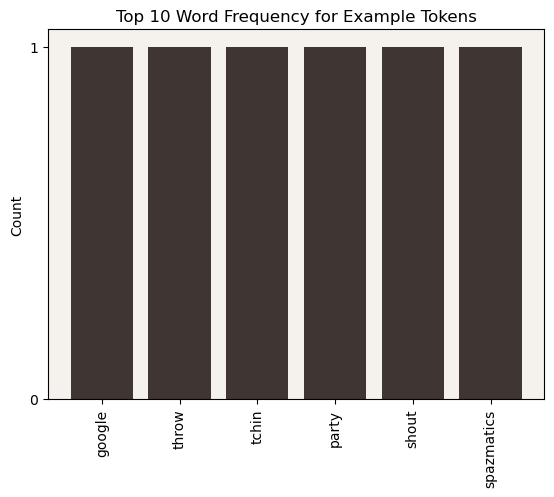

In [67]:
# Importing the relevant package for top number of words
from matplotlib.ticker import MaxNLocator

# Creating a function to visualize the top 10 words

def visualize_top_10(freq_dist, title):
#     extracting data for graph
    top_10 = list(zip(*freq_dist.most_common(10)))
    tokens = top_10[0]
    counts = top_10[1]
    
#     Setting up graph and plotting data
    fig, ax = plt.subplots()
    ax.bar(tokens, counts, color='#3F3533')
    ax.set_facecolor('#F5F2EE')
#     Custominzing plot appearance 
    ax.set_title(title)
    ax.set_ylabel('Count')
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(axis='x', rotation=90)
    
visualize_top_10(example_freq_dist, "Top 10 Word Frequency for Example Tokens")

* **FreqDist on the Full DataSet**

In order to calculate the count of words, they need to be stored into a list. To do so, we will `explode` the dataset.  

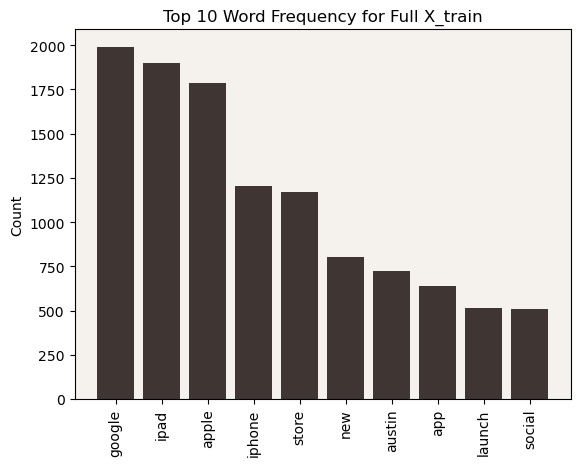

In [68]:
# Creating a frequency distribution for X_train
train_freq_dist = FreqDist(X_train['tweet'].explode())

# Plotting the top 10 tokens
visualize_top_10(train_freq_dist, 'Top 10 Word Frequency for Full X_train')


In [69]:
train_freq_dist.most_common(20)

[('google', 1990),
 ('ipad', 1897),
 ('apple', 1784),
 ('iphone', 1203),
 ('store', 1168),
 ('new', 804),
 ('austin', 721),
 ('app', 641),
 ('launch', 515),
 ('social', 509),
 ('circle', 508),
 ('pop', 459),
 ('android', 442),
 ('today', 433),
 ('ipad2', 361),
 ('network', 356),
 ('get', 343),
 ('via', 331),
 ('line', 325),
 ('party', 299)]

We can also subdivide this by category to see if it makes a difference:

In [70]:
# Adding in labels for filtering
X_train['label'] = [y_train[val] for val in X_train.index]

In [71]:
custom_colors = ['#3F3533', '#F5F2EE']

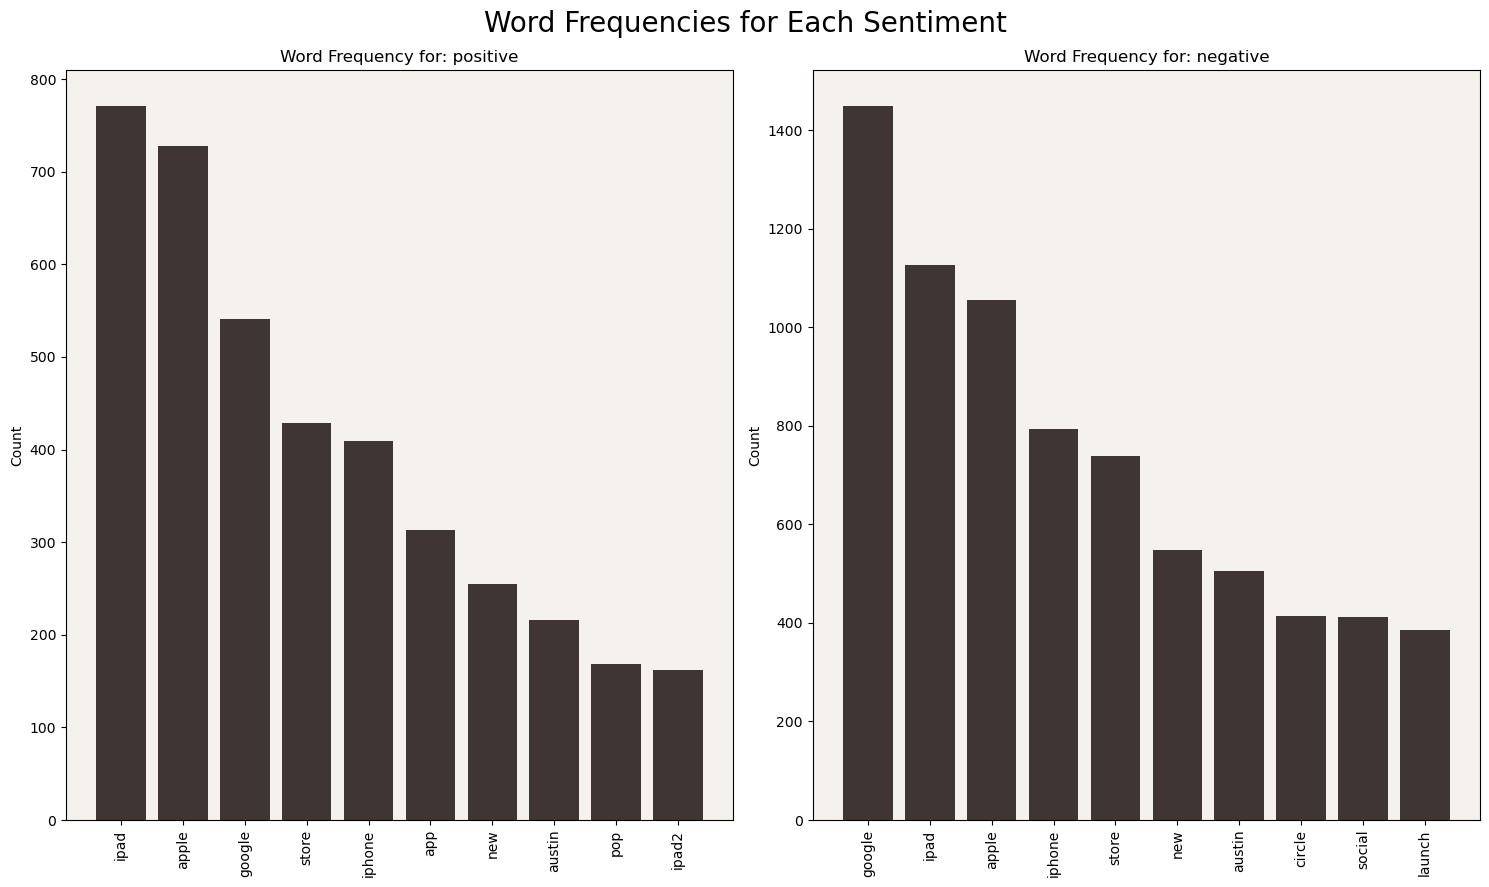

In [72]:
# Defining funcrion to plot 2 visualizations

# Creating two columns 
def two_subplits():
    fig = plt.figure(figsize=(15, 9))
    fig.set_tight_layout(True)
    gs = fig.add_gridspec(1, 2)
    
    ax1 = fig.add_subplot(gs[0, 0]) #row 0, col 0 
    ax2 = fig.add_subplot(gs[0, 1]) #row 0, col 1 
    return fig, [ax1, ax2]

# Plotting the graph
def plot_distribution_by_sentiment(X_version, column, axes, title = "Word Frequency for:"):
    for index, category in enumerate(X_version['label'].unique()): 
#         Calculating frequency distribution for this subset
        all_words = X_version[X_version['label'] == category][column].explode()
        freq_dist = FreqDist(all_words)
        top_10 = list(zip(*freq_dist.most_common(10)))
        tokens = top_10[0]
        counts = top_10[1]
        
        
#         Setting up a plot
        ax = axes[index]
        ax.bar(tokens, counts, color='#3F3533')
        
#         Setting background color
        ax.set_facecolor('#F5F2EE')
    
#         Customizing plot appearance
        ax.set_title(f"{title} {category}")
        ax.set_ylabel("Count")
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        ax.tick_params(axis='x', rotation=90)
 
        
fig, axes = two_subplits()
plot_distribution_by_sentiment(X_train, 'tweet', axes)
fig.suptitle('Word Frequencies for Each Sentiment', fontsize=20)
plt.show()

In [73]:
# Frequency distribution
# Defining subset prior. Here: positive, negative, no company tweets

negative_tweets = X_train[X_train['label'] == 'negative']
positive_tweets = X_train[X_train['label'] == 'positive']
no_product_or_company = X_train[X_train['product_or_company'] == 'undefined']

def freq_distr(subset, most_common):
    exploded_subset = subset['tweet'].explode()
    subset_freq = FreqDist(exploded_subset)
    return subset_freq.most_common(most_common)



In [74]:
# Getting frequency distribution for top 20 strings of no_product_or_company
freq_distr(no_product_or_company, 20)

[('google', 1392),
 ('ipad', 1034),
 ('apple', 1001),
 ('store', 733),
 ('iphone', 719),
 ('new', 550),
 ('austin', 504),
 ('social', 404),
 ('circle', 402),
 ('launch', 381),
 ('today', 334),
 ('app', 311),
 ('android', 291),
 ('pop', 286),
 ('network', 279),
 ('via', 236),
 ('called', 223),
 ('line', 209),
 ('free', 207),
 ('ipad2', 203)]

### 4: 2- g) Wordcloud

In [75]:
# Installing wordcloud
# !pip install --trusted-host pypi.org --trusted-host pypi.python.org --trusted-host=files.pythonhosted.org wordcloud

In [76]:
# Importing relevant packages
from matplotlib.colors import LinearSegmentedColormap

# Defining a colormap that interpolates between the two defined colors
custom_colors = ['#3F3533', '#F5F2EE']

n_bins = 5 

# Creating the custom colormap
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", custom_colors, N=n_bins)

In [77]:
# Importing relevant packages 
from wordcloud import WordCloud

# Concatenate all tweets into a single string
all_tweets = ' '.join(X_train['tweet'].apply(lambda x: ' '.join(map(str, x))))

def wordcloud_graph(text):
    
    # Generate a word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='#F5F2EE', colormap=custom_cmap).generate(all_tweets)

    # Display the generated word cloud using matplotlib
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()


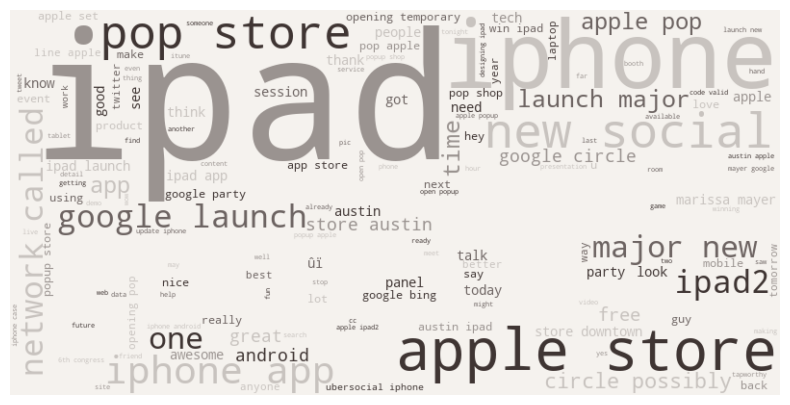

In [78]:
wordcloud_graph(all_tweets)

In [79]:
# If any word need to be reserarched
word_researched = 'quot'
filtered_on_word = X_train[X_train['tweet'].apply(lambda tweet_list: any(word_researched in s for s in tweet_list))]
# filtered_on_word

Whether it comes from the frequency distribution or word cloud, the product and companies are the words that come up the most. 64% of the data does not contain any company or product. We will try filtering on this one to understand if the top words are different.  

In [80]:
# Verifying the count of rows by unique value in this column
df['product_or_company'].value_counts(normalize=True)

undefined                          0.638148
iPad                               0.104190
Apple                              0.072657
iPad or iPhone App                 0.051709
Google                             0.047189
iPhone                             0.032635
Other Google product or service    0.032304
Android App                        0.008820
Android                            0.008490
Other Apple product or service     0.003859
Name: product_or_company, dtype: float64

* **No company**

In [81]:
# Create dataframe for undefined product or company
no_company = X_train[X_train['product_or_company'] == 'undefined']

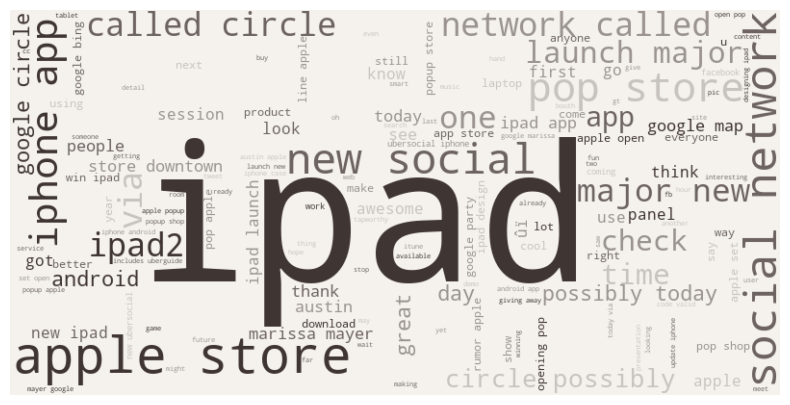

In [82]:
# Concatenate all tweets into a single string
no_company_tweets = ' '.join(no_company['tweet'].apply(lambda x: ' '.join(map(str, x))))

# Drawing the wordcloud on the list including only 'undefined' companies or products
wordcloud_graph(no_company_tweets)

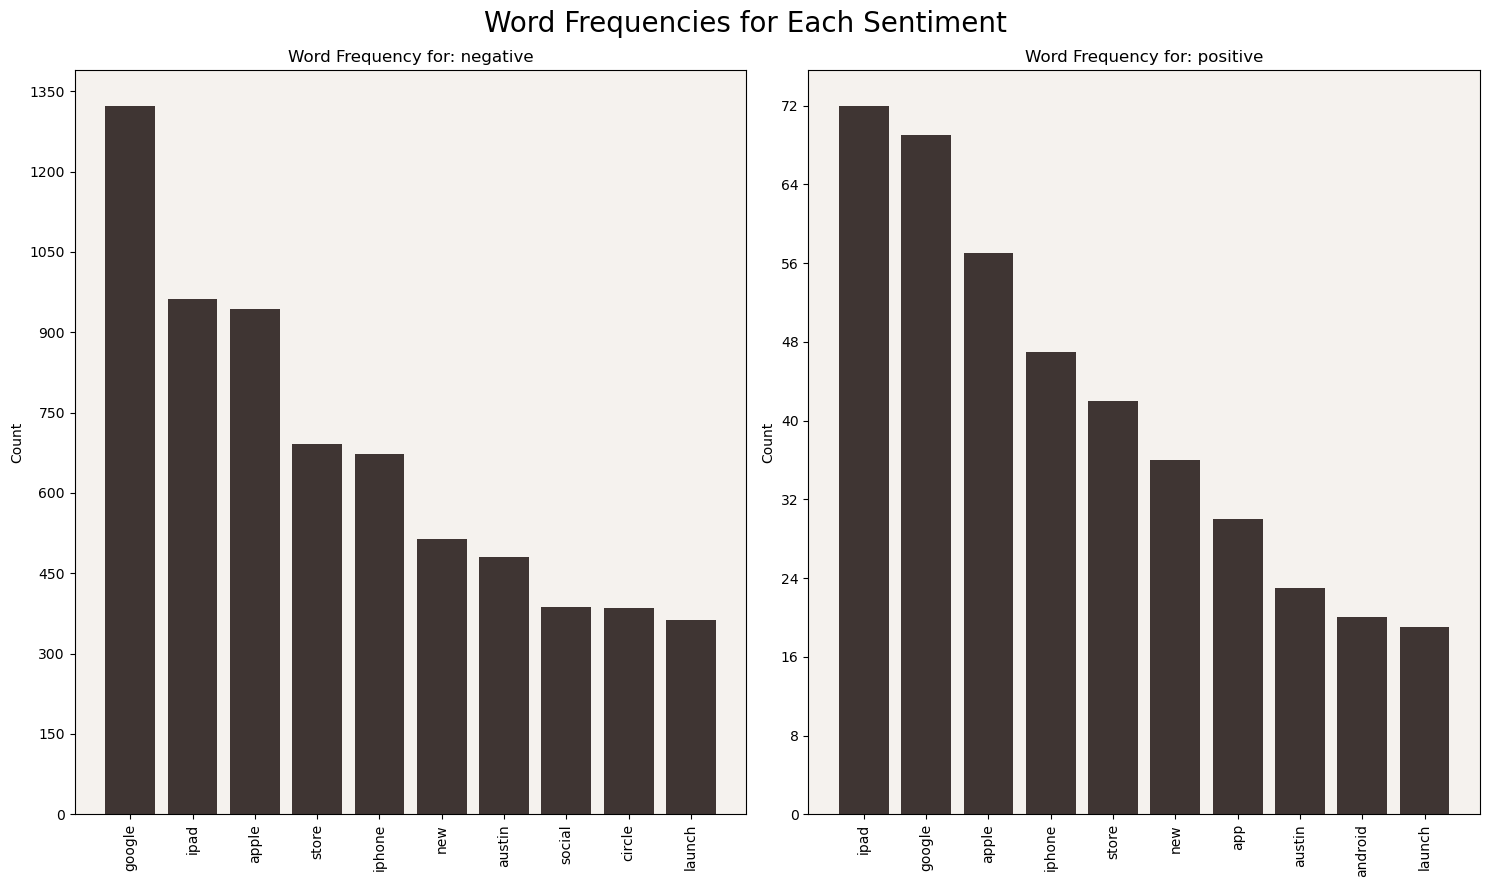

In [83]:
fig, axes = two_subplits()
plot_distribution_by_sentiment(no_company, 'tweet', axes)
fig.suptitle('Word Frequencies for Each Sentiment', fontsize=20)
plt.show()

* **Company only**

In [84]:
# Create dataframe for only product or company
company_only = X_train[X_train['product_or_company'] != 'undefined']

In [85]:
# Inspecting company_only DataFrame
company_only.head()

,tweet,product_or_company,tweet_original,tokenized_tweet,label
8268,"[huge, shout, gsdm, google, kick, as, party, tonight, unbelievable, time]",Google,Huge shout out to GSDM &amp; Google for the kick ass party tonight! We had an unbelievable time. #SXSW,huge shout gsdm google kick as party tonight unbelievable time,positive
7771,"[awesome, yes, gowalla, win, best, andoid, app, team, android, choice, award, thanks]",Android App,Awesome! RT @mention Yes! Gowalla wins best Andoid app at the Team Android Choice Awards. Thanks all! #sxsw,awesome yes gowalla win best andoid app team android choice award thanks,positive
1643,"[justmet, worked, apple, 25, year]",Apple,#justmet @mention who worked for Apple for 25 years! #SXSW,justmet worked apple 25 year,positive
6986,"[yes, updated, iphone, app, song, info, 24, stream, others, also, live, video, streaming]",iPad or iPhone App,RT @mention YES! updated iPhone app has song info @mention 24/7 stream +others also live video streaming for #SXSW {link},yes updated iphone app song info 24 stream others also live video streaming,positive
9029,"[top, story, apple, school, marketing, expert, thousand, town, demonstrate, social, mar]",Apple,"[TOP STORY] At #SXSW, Apple schools the marketing experts: Thousands in town to demonstrate their social mar... {link} #sxswi",top story apple school marketing expert thousand town demonstrate social mar,positive


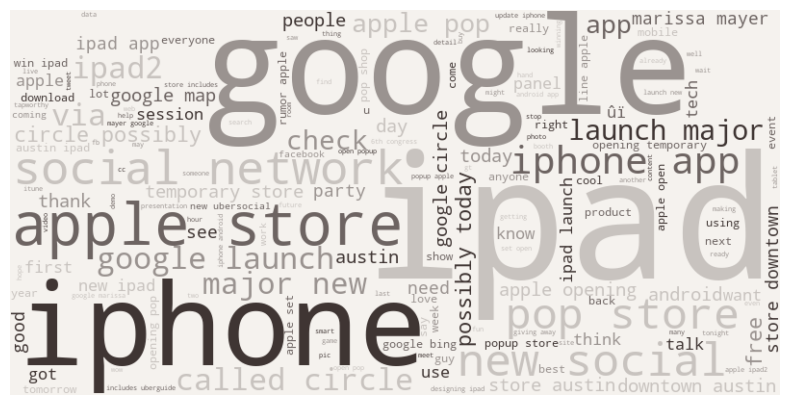

In [86]:
# Concatenate all tweets into a single string
company_tweets = ' '.join(no_company['tweet'].apply(lambda x: ' '.join(map(str, x))))

wordcloud_graph(company_tweets)

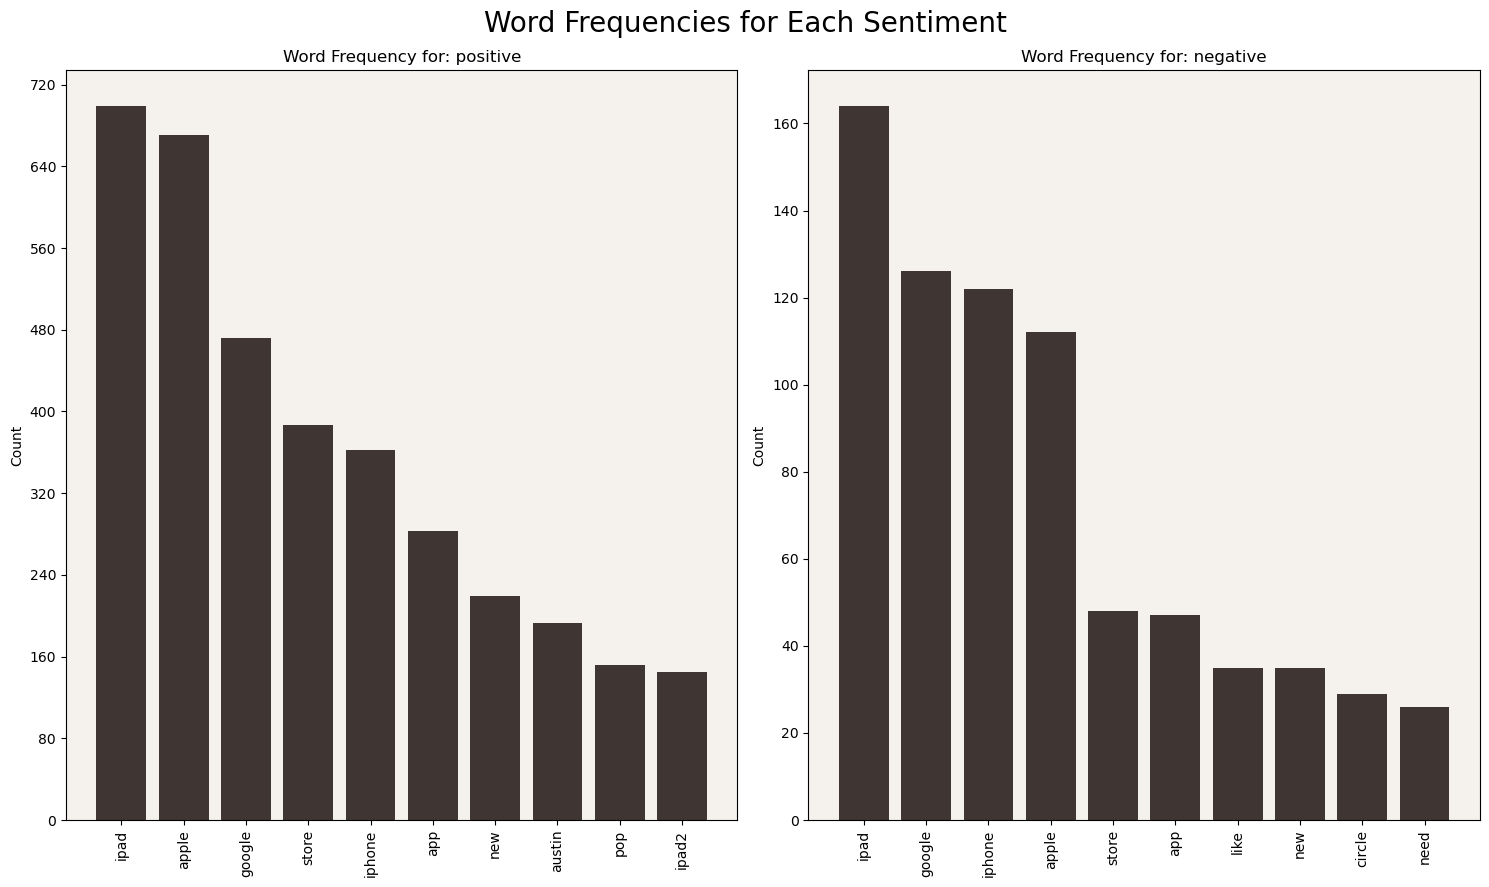

In [87]:
fig, axes = two_subplits()
plot_distribution_by_sentiment(company_only, 'tweet', axes)
fig.suptitle('Word Frequencies for Each Sentiment', fontsize=20)
plt.show()

* **No company words**
<br>Because it does not matter much what product or company is mentioned, all these words will be removed.

In [88]:
# Defining list of product or company name to remove
list_of_company_products = ['google', 'android', 'apple', 'ipad', 'iphone', 'ipad2']
# Making a copy of the dataframe to first evaluate
no_product_company = X_train.copy()

In [89]:
no_product_company.head()

,tweet,product_or_company,tweet_original,tokenized_tweet,label
8268,"[huge, shout, gsdm, google, kick, as, party, tonight, unbelievable, time]",Google,Huge shout out to GSDM &amp; Google for the kick ass party tonight! We had an unbelievable time. #SXSW,huge shout gsdm google kick as party tonight unbelievable time,positive
945,"[20, google, search, local, information, marissa, mayer, million, place, claimed, owner, logged, google]",undefined,#SXSW 20% of Google searches are for local information: Marissa Mayer. 6 million places claimed by their owners and logged by #Google,20 google search local information marissa mayer million place claimed owner logged google,negative
8832,"[free, playlist, enjoy]",undefined,free #sxsw playlist.. enjoy {link},free playlist enjoy,negative
7771,"[awesome, yes, gowalla, win, best, andoid, app, team, android, choice, award, thanks]",Android App,Awesome! RT @mention Yes! Gowalla wins best Andoid app at the Team Android Choice Awards. Thanks all! #sxsw,awesome yes gowalla win best andoid app team android choice award thanks,positive
1643,"[justmet, worked, apple, 25, year]",Apple,#justmet @mention who worked for Apple for 25 years! #SXSW,justmet worked apple 25 year,positive


In [90]:
# Removing any word corresponding to product or company
no_product_company['tweet'] = no_product_company['tweet'].apply(
    lambda tweet_list: [word for word in tweet_list if word.lower() not in list_of_company_products]
)

In [91]:
# Verifying if words were removed at first glance
no_product_company.head()

,tweet,product_or_company,tweet_original,tokenized_tweet,label
8268,"[huge, shout, gsdm, kick, as, party, tonight, unbelievable, time]",Google,Huge shout out to GSDM &amp; Google for the kick ass party tonight! We had an unbelievable time. #SXSW,huge shout gsdm google kick as party tonight unbelievable time,positive
945,"[20, search, local, information, marissa, mayer, million, place, claimed, owner, logged]",undefined,#SXSW 20% of Google searches are for local information: Marissa Mayer. 6 million places claimed by their owners and logged by #Google,20 google search local information marissa mayer million place claimed owner logged google,negative
8832,"[free, playlist, enjoy]",undefined,free #sxsw playlist.. enjoy {link},free playlist enjoy,negative
7771,"[awesome, yes, gowalla, win, best, andoid, app, team, choice, award, thanks]",Android App,Awesome! RT @mention Yes! Gowalla wins best Andoid app at the Team Android Choice Awards. Thanks all! #sxsw,awesome yes gowalla win best andoid app team android choice award thanks,positive
1643,"[justmet, worked, 25, year]",Apple,#justmet @mention who worked for Apple for 25 years! #SXSW,justmet worked apple 25 year,positive


In [92]:
# Actively searching for a word
word_researched = 'ipad'
filtered_on_word = no_product_company[no_product_company['tweet'].apply(lambda tweet_list: any(word_researched in s for s in tweet_list))]

In [93]:
# Calling new dataframe filtered on word
filtered_on_word.head()

,tweet,product_or_company,tweet_original,tokenized_tweet,label
279,"[technews, opening, pop, store, austin, geekfest, tech_news, brian_lam, ipad_2, tech]",undefined,#technews Apple Opening Pop-Up Store in Austin for SXSW Geekfest [Apple] {link} #Tech_News #Apple #Brian_Lam #iPad_2 #SXSW #tech,technews apple opening pop store austin geekfest apple tech_news apple brian_lam ipad_2 tech,negative
8363,"[hate, fleet, nerd, armed, ipads, navigating, crowd, far, cool, ever, seen]",iPad,"Not to hate on the iPad, but fleets of nerds armed with iPads navigating through crowds is as far from cool as I've EVER seen #sxsw",hate ipad fleet nerd armed ipads navigating crowd far cool ever seen,negative
5541,"[bad, news, update, pop, store, ipads, sure, tomorrow]",undefined,RT @mention Bad news update: the pop-up Apple Store is out of iPads! Not sure if they will have more by tomorrow. #SXSW,bad news update pop apple store ipads sure tomorrow,negative
6696,"[surprise, opened, pop, store, austin, nerd, town, get, new, ipads, cnet]",undefined,RT @mention Surprise! Apple opened a pop-up store in Austin so that the nerds in town for #SXSW can get new iPads. {link} #cnet,surprise apple opened pop store austin nerd town get new ipads cnet,negative
4103,"[picked, great, venue, launch, new, ipads]",Apple,#SXSW Apple picked a great venue to launch the new Ipads.,apple picked great venue launch new ipads,positive


In [94]:
# Concatenate all tweets into a single string
no_prod_comp_list = ' '.join(no_product_company['tweet'].apply(lambda x: ' '.join(map(str, x))))

# wordcloud_graph(no_prod_comp_list)

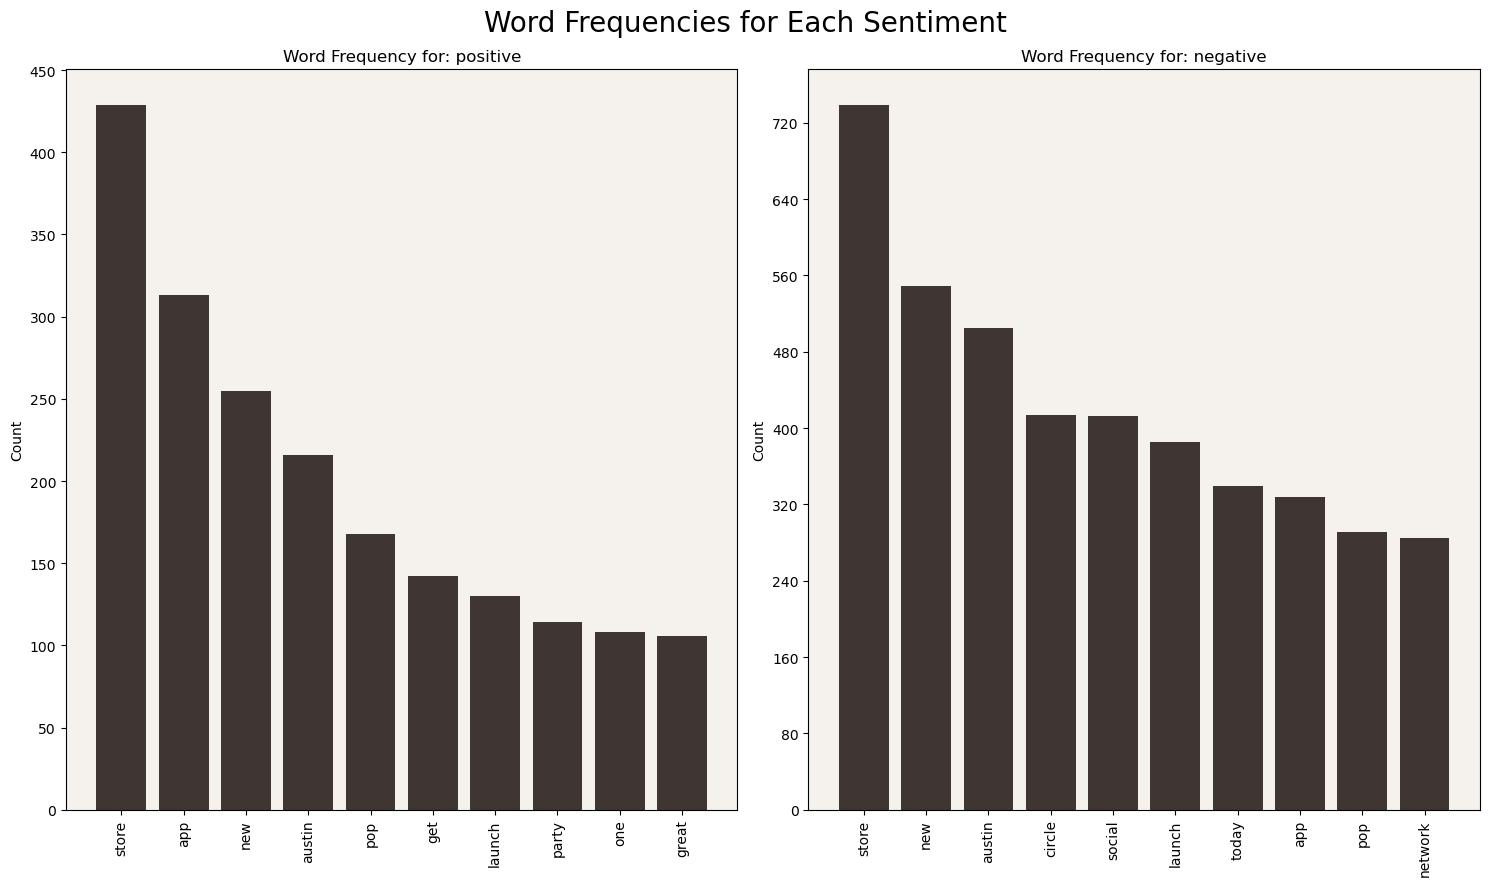

In [95]:
fig, axes = two_subplits()
plot_distribution_by_sentiment(no_product_company, 'tweet', axes)
fig.suptitle('Word Frequencies for Each Sentiment', fontsize=20)
plt.show()

In [96]:
# Getting frequency for no_prod_company_tweets
# no_product_company 
positive_tweets_no_comp = no_product_company[no_product_company['label'] == 'positive']
negative_tweets_no_comp = no_product_company[no_product_company['label'] == 'negative']

In [97]:
freq_distr(no_product_company, 20)

[('store', 1168),
 ('new', 804),
 ('austin', 721),
 ('app', 641),
 ('launch', 515),
 ('social', 509),
 ('circle', 508),
 ('pop', 459),
 ('today', 433),
 ('network', 356),
 ('get', 343),
 ('via', 331),
 ('line', 325),
 ('party', 299),
 ('free', 284),
 ('called', 269),
 ('mobile', 263),
 ('one', 243),
 ('time', 227),
 ('major', 223)]

In [98]:
freq_distr(positive_tweets_no_comp, 20)

[('store', 429),
 ('app', 313),
 ('new', 255),
 ('austin', 216),
 ('pop', 168),
 ('get', 142),
 ('launch', 130),
 ('party', 114),
 ('one', 108),
 ('great', 106),
 ('line', 103),
 ('time', 101),
 ('social', 96),
 ('via', 95),
 ('circle', 94),
 ('today', 94),
 ('win', 93),
 ('map', 90),
 ('day', 90),
 ('cool', 89)]

In [99]:
freq_distr(negative_tweets_no_comp, 20)

[('store', 739),
 ('new', 549),
 ('austin', 505),
 ('circle', 414),
 ('social', 413),
 ('launch', 385),
 ('today', 339),
 ('app', 328),
 ('pop', 291),
 ('network', 285),
 ('via', 236),
 ('called', 222),
 ('line', 222),
 ('get', 201),
 ('free', 195),
 ('mobile', 187),
 ('party', 185),
 ('major', 180),
 ('possibly', 146),
 ('temporary', 139)]

Having filtered on no company tweets give us a better idea: positive tweets talk about...
<br>negative tweets talk about ... 

Let's review bigrams to get a better understanding. 

### 4: 2- h) Bigrams

#### Bigrams

* **All tweets**

In [100]:
# Importing relevant package
from nltk.collocations import *

# Storing nltk.collocations.BigramAssocMeasures into variable
bigram_measures = nltk.collocations.BigramAssocMeasures()

In [101]:
# Defining a function to review bigrams
def bigram_review(text, top_n):
    # Creating a finder and passing it the words of tweets summarized as 1 list  
    text_finder = BigramCollocationFinder.from_words(text.sum())
    text_scored = text_finder.score_ngrams(bigram_measures.raw_freq)
    return text_scored[: top_n]


In [102]:
bigram_review(no_product_company['tweet'], 20)

[(('pop', 'store'), 0.006248214795772636),
 (('social', 'network'), 0.006105398457583547),
 (('new', 'social'), 0.005551985147100829),
 (('called', 'circle'), 0.004480862610682662),
 (('network', 'called'), 0.004302342187946301),
 (('major', 'new'), 0.0038381890888317624),
 (('launch', 'major'), 0.0036953727506426736),
 (('temporary', 'store'), 0.0033204798628963155),
 (('circle', 'possibly'), 0.003124107397886318),
 (('possibly', 'today'), 0.003088403313339046),
 (('store', 'austin'), 0.002767066552413596),
 (('downtown', 'austin'), 0.0025528420451299627),
 (('marissa', 'mayer'), 0.002356469580119966),
 (('store', 'downtown'), 0.0023029134532990573),
 (('popup', 'store'), 0.002070836903741788),
 (('opening', 'temporary'), 0.001570979720079977),
 (('austin', 'launch'), 0.0014817195087117967),
 (('app', 'store'), 0.001356755212796344),
 (('pop', 'shop'), 0.0011246786632390746),
 (('opening', 'pop'), 0.0010532704941445302)]

We saw earlier that the tweets containing company names or products indicated too many of of these strings, and were not relevant for us. We will straight away separate positive and negative tweets from the dataset that contains no product or company information. 

In [103]:
# They were declared before
# positive_tweets_no_comp = no_product_company[no_product_company['label'] == 'positive']
# negative_tweets_no_comp = no_product_company[no_product_company['label'] == 'negative']

* **Positive Tweets**

In [104]:
bigram_review(positive_tweets_no_comp['tweet'], 20)

[(('pop', 'store'), 0.0068745263613727405),
 (('social', 'network'), 0.0035725885027606367),
 (('temporary', 'store'), 0.00319367760095269),
 (('new', 'social'), 0.003139547472122984),
 (('downtown', 'austin'), 0.002923026956804157),
 (('store', 'downtown'), 0.0027606365703150373),
 (('marissa', 'mayer'), 0.0024899859261665043),
 (('called', 'circle'), 0.0024358557973367975),
 (('network', 'called'), 0.002381725668507091),
 (('popup', 'store'), 0.002381725668507091),
 (('launch', 'major'), 0.0021652051531882645),
 (('major', 'new'), 0.0021652051531882645),
 (('store', 'austin'), 0.0021652051531882645),
 (('opening', 'temporary'), 0.0017321641225506116),
 (('circle', 'possibly'), 0.001678033993720905),
 (('possibly', 'today'), 0.001678033993720905),
 (('even', 'begin'), 0.001569773736061492),
 (('austin', 'launch'), 0.0014615134784020786),
 (('come', 'cool'), 0.0014615134784020786),
 (('go', 'conference'), 0.001407383349572372)]

There is enthusiasm with the new pop up store created. And about the new social network created circle. 
High enthusiasm anout the new launch and the Marissa Mayer. 

* **Negative Tweets**

In [105]:
bigram_review(negative_tweets_no_comp['tweet'], 20)

[(('social', 'network'), 0.007351766022055298),
 (('new', 'social'), 0.00673911885355069),
 (('pop', 'store'), 0.005940013851153375),
 (('called', 'circle'), 0.0054871876831282295),
 (('network', 'called'), 0.005247456182409035),
 (('major', 'new'), 0.004661445847317671),
 (('launch', 'major'), 0.0044483511800117205),
 (('circle', 'possibly'), 0.003835704011507112),
 (('possibly', 'today'), 0.0037824303446806246),
 (('temporary', 'store'), 0.003382877843481967),
 (('store', 'austin'), 0.003063235842523041),
 (('downtown', 'austin'), 0.0023706781737787013),
 (('marissa', 'mayer'), 0.00229076767353897),
 (('store', 'downtown'), 0.002077673006233019),
 (('popup', 'store'), 0.001917852005753556),
 (('austin', 'launch'), 0.0014916626711416548),
 (('opening', 'temporary'), 0.0014916626711416548),
 (('app', 'store'), 0.0013318416706621916),
 (('opening', 'pop'), 0.0010921101699429973),
 (('launch', 'new'), 0.0010654733365297534)]

### 4: 2- i) Mutual Information Scores

We will calculate mutual information scores and we will create a frequency filter, so that we only examine bigrams that occur more than a set number of times: here, 5. 

In [106]:
def mutual_info_score(text, n_filter):
    text_pmi_finder = BigramCollocationFinder.from_words(text.sum())
    text_pmi_finder.apply_freq_filter(n_filter)
    text_pmi_scored = text_pmi_finder.score_ngrams(bigram_measures.pmi)
    return text_pmi_scored

In [107]:
mutual_info_score(no_product_company['tweet'], 5)[:10]

[(('barton', 'hollow'), 13.451623251541143),
 (('mover', 'shaker'), 13.451623251541143),
 (('charles', 'chen'), 13.188588845707347),
 (('jc', 'penney'), 13.188588845707347),
 (('rww', 'f6bcet'), 13.188588845707347),
 (('entered', 'automatically'), 12.9661964243709),
 (('hobo', 'shotgun'), 12.9661964243709),
 (('khoi', 'vinh'), 12.9661964243709),
 (('98', 'accuracy'), 12.773551346428505),
 (('cameron', 'sinclair'), 12.773551346428505)]

In [108]:
mutual_info_score(positive_tweets_no_comp['tweet'], 5)[:10]

[(('league', 'extraordinary'), 11.851280557878614),
 (('lustre', 'pearl'), 11.851280557878614),
 (('security', 'guard'), 11.588246152044817),
 (('south', 'southwest'), 11.36585373070837),
 (('speech', 'therapy'), 11.36585373070837),
 (('150', 'million'), 11.173208652765974),
 (('maggie', 'mae'), 11.173208652765974),
 (('belinsky', '911tweets'), 10.980563574823577),
 (('mark', 'belinsky'), 10.980563574823577),
 (('awesomely', 'rad'), 10.85128055787861)]

In [109]:
mutual_info_score(negative_tweets_no_comp['tweet'], 5)[:10]

[(('acoustic', 'solo'), 12.611255388699337),
 (('charles', 'chen'), 12.611255388699337),
 (('entered', 'automatically'), 12.611255388699337),
 (('jc', 'penney'), 12.611255388699337),
 (('khoi', 'vinh'), 12.611255388699337),
 (('rww', 'f6bcet'), 12.611255388699337),
 (('98', 'accuracy'), 12.38886296736289),
 (('galaxy', 'ii'), 12.38886296736289),
 (('lustre', 'pearl'), 12.38886296736289),
 (('cameron', 'sinclair'), 12.196217889420495)]

modeling
<a id='modeling'></a>

## 5. Modeling

-----------------------------HERE-----------------------------

We want to predict both positive and negative sentiments. A false positive would have more impact, because we would base our strategy based on a tweet we thought would positively impact whereas it was actually negative. 
<br>Consequently, F1 will be chosen in addition to accuracy. 




Class Imbalance:

When the classes in your dataset are imbalanced, meaning that one class significantly outnumbers the other, accuracy alone might be misleading. F1-score considers both false positives and false negatives and is particularly useful in imbalanced datasets.


Cost of False Positives and False Negatives is Similar:

If the costs associated with false positives and false negatives are similar, F1-score can be a good metric. F1-score provides a balance between minimizing false positives and false negatives.

-----------------------------HERE-----------------------------

In [110]:
# Recall the natural split
y_train.value_counts(normalize=True)

negative    0.672596
positive    0.327404
Name: sentiment, dtype: float64

In [111]:
# If we were to guess that a tweet was positive, we would only get 33% accuracy. 

### 5. a) Baseline Model with TfidfVectorizer and MultinomialNB

We will start modeling by building an initial model which only has access to the information in the plots above. So, using the default token pattern to split the full text into tokens, and using a limited vocabulary. 

To give the model a little bit more information with those same features, `TfidVectorizer` will be used to count the term frequency (`tf`) within a single document. This package also includes the inverse document frequency (`idf`): how rare the term is. 

The first step is to import the vectorizer, instantiate a vectorizer object and fit it on `X_train['tweet']`.

In [112]:
# Calling the function to display the confusion matrix
# confusion_matrix_display(baseline_model, cnf_matrix_b)

The precision score returns 0 most likely because it is under represented : <br>
**Verifying the class balance**

In [113]:
y_train.value_counts()

negative    4575
positive    2227
Name: sentiment, dtype: int64

In [114]:
# Verifying the class balance
y_train.value_counts(normalize=True)

negative    0.672596
positive    0.327404
Name: sentiment, dtype: float64

How well did the final model perform?

If we guessed the contribution of positive sentiment every time, we would expect about 33% accuracy. 
Our model baseline is not getting more than just getting every time.  

### <u>1st iteration</u>: Tfidf Vectorizer with Pipeline 

    1) Fitting and training train data

In [115]:
# Importing the relevant packages
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

# Define the pipeline steps
tfidf_vectorizer = TfidfVectorizer(max_features=10)
naive_bayes_classifier = MultinomialNB()

# Create the pipeline
base_pipeline = Pipeline([
    ('tfidf', tfidf_vectorizer),
    ('classifier', naive_bayes_classifier)
])

# Fitting the pipeline on X_train['tweet_original'] and y_train
base_pipeline.fit(X_train['tweet_original'], y_train)

# Calculating predictions using this model
base_y_pred = base_pipeline.predict(X_test['tweet_original'])

# Optionally, you can access the individual components of the pipeline:
X_train_vectorized = base_pipeline.named_steps['tfidf'].transform(X_train['tweet_original'])
baseline_model = base_pipeline.named_steps['classifier']

    2) Evaluation Metrics

In [116]:
# Importing the relevant packages
from sklearn.metrics import precision_score, accuracy_score, f1_score
from sklearn.model_selection import cross_val_score

def evaluation_metrics(y_test, y_pred, model, X, y):
    with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
    
    # Calculating and printing accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.4f}')

    # Calculating and printing F1-score
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f'F1-Score: {f1:.4f}')
    
    # Calculating and printing precision
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    print(f'Precision: {precision:.4f}')

    # Performing cross-validation and printing the mean accuracy
    cv_scores = cross_val_score(model, X, y, cv=5)
    mean_cv_accuracy = cv_scores.mean()
    print(f'Mean Cross-Validated Accuracy: {mean_cv_accuracy:.4f}')
    
    return accuracy, f1, precision, mean_cv_accuracy

In [117]:
# Naming the model and calling the function to evaluate it
baseline_model_name = 'Baseline'

# Calling the function and recording into the defined values
accuracy_base, precision_base, f1_base, cv_base = evaluation_metrics(
    y_test, 
    base_y_pred, 
    base_pipeline, 
    X_train['tweet_original'], 
    y_train)

Accuracy: 0.6724
F1-Score: 0.5407
Precision: 0.4521
Mean Cross-Validated Accuracy: 0.6726


    3) Classification Report

In [118]:
# Defining a function to print a classification report

import warnings
from sklearn.metrics import classification_report

def class_calculation(y_test, y_pred):
    # y_preds will be calculated for each model beforehand 
    
    # Generating and printing classification report
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
    class_report = classification_report(y_test, y_pred, zero_division=0, digits=5)
    
    # Due to class imbalance, the initial precision for positive returns 0 
    # Consequently, warnings need to be handled 
    print('Classification Report:\n', class_report)
    return class_report
    
    


In [119]:
base_class_report = class_calculation(y_test, base_y_pred)

Classification Report:
               precision    recall  f1-score   support

    negative    0.67240   1.00000   0.80411      1525
    positive    0.00000   0.00000   0.00000       743

    accuracy                        0.67240      2268
   macro avg    0.33620   0.50000   0.40206      2268
weighted avg    0.45212   0.67240   0.54068      2268



    4) Confusion Matrix

In [120]:
# Importing relevant packages
from matplotlib.colors import LinearSegmentedColormap

# Defining a colormap that interpolates between the two defined colors
custom_colors_cnf = ['#3F3533', '#F5F2EE']

n_bins = 20 

# Creating the custom colormap
custom_cmap_cnf = LinearSegmentedColormap.from_list("custom_cmap", custom_colors_cnf, N=n_bins)

In [121]:
# Displaying visually the confusion matrix 

# Importing the relevant package 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

def confusion_matrix_display(model, y_test, y_pred):
    # Defining the confusion matrix 
    cnf_matrix = confusion_matrix(y_test, y_pred)
#     print(cnf_matrix)
    
    # Normalizing the confusion matrix
    cnf_matrix_normalized = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]

    disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix_normalized, display_labels=model.classes_)

    disp.plot(cmap=custom_cmap_cnf)

    plt.title("Model Performance: Confusion Matrix", fontsize=16)

    # Saving the plot as a PNG with a transparent background
    plt.savefig('images/confusion_matrix.png', transparent=True)

    return cnf_matrix
    plt.show()
    

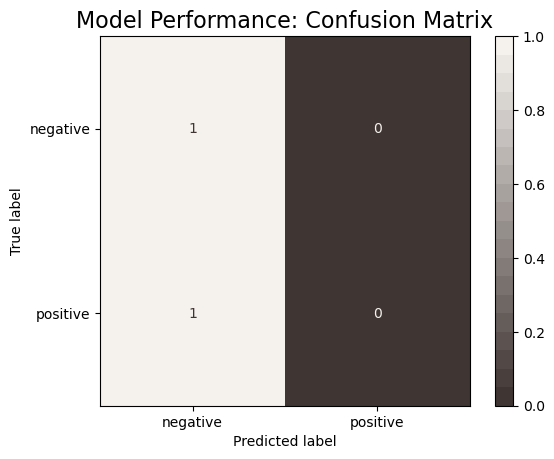

In [122]:
base_cfn_matrix = confusion_matrix_display(base_pipeline, y_test, base_y_pred)

### <u>2nd iteration</u>: Addressing class imbalance: undersampling negative tweets

    1) Fitting and training train data

In [123]:
print('Length X_train: ' + str(len(X_train['tweet_original'])))
print('Length y_train: ' + str(len(y_train)))

Length X_train: 6802
Length y_train: 6802


In [124]:
# Import relevant packages
from imblearn.under_sampling import RandomUnderSampler
import imblearn.pipeline

Now that we have preprocessed data, we will fit and evaluate the baseline model on the newly resampled data.

In [125]:
# Defining the pipeline steps
tfidf_vectorizer = TfidfVectorizer(max_features=10)
naive_bayes_classifier = MultinomialNB()

# Including the UnderSampler to the pipeline
rs_pipeline = imblearn.pipeline.Pipeline([
    ('tfidf', tfidf_vectorizer),
    ('us', RandomUnderSampler(random_state=42)),
    ('classifier', naive_bayes_classifier)
])

# Fitting the pipeline on X_train['tweet_original'] and y_train
rs_pipeline.fit(X_train['tweet_original'], y_train)

rs_y_pred = rs_pipeline.predict(X_test['tweet_original']) 


In [126]:
# Verifying the value counts of each category, before undersampling
original_value_counts = y_train.value_counts()
print("Original class distribution:")
print(original_value_counts)

# Getting the indices of the resampled data
resampled_indices = rs_pipeline.named_steps['us'].sample_indices_

# Verifying the new value counts of each category, after undersampling
resampled_value_counts = y_train.iloc[resampled_indices].value_counts()
print("\nClass distribution after undersampling:")
print(resampled_value_counts)


Original class distribution:
negative    4575
positive    2227
Name: sentiment, dtype: int64

Class distribution after undersampling:
negative    2227
positive    2227
Name: sentiment, dtype: int64


    2) Evaluation Metrics

In [127]:
# Naming the model
resampled_model_name = 'Resampled'

# Calling the function and recording into the defined values
accuracy_rs, f1_rs, precision_rs, cv_rs = evaluation_metrics(
    y_test, 
    rs_y_pred, 
    rs_pipeline, 
    X_train['tweet_original'], 
    y_train)

Accuracy: 0.5692
F1-Score: 0.5806
Precision: 0.6030
Mean Cross-Validated Accuracy: 0.5706


The accuracy score drastically decreased, but we now have a precision and f1 scores, indicating the 'positive sentiments' are now correctly represented.  

    3) Classification Report

In [128]:
resamp_class_report = class_calculation(y_test, rs_y_pred)

Classification Report:
               precision    recall  f1-score   support

    negative    0.71175   0.60393   0.65342      1525
    positive    0.37988   0.49798   0.43098       743

    accuracy                        0.56922      2268
   macro avg    0.54581   0.55096   0.54220      2268
weighted avg    0.60303   0.56922   0.58055      2268



    4) Confusion Matrix

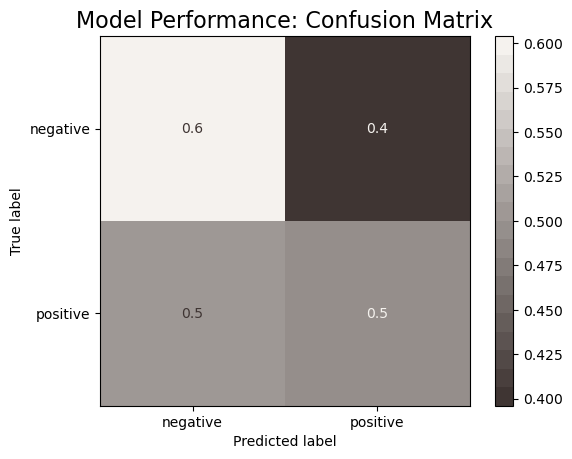

In [129]:
rs_cfn_matrix = confusion_matrix_display(rs_pipeline, y_test, rs_y_pred)

### <u>4th iteration</u>: including stopwords

    1) Fitting and training train data

In [130]:
# Defining the pipeline steps, including the stopwords_list created 
tfidf_vectorizer = TfidfVectorizer(max_features=10, stop_words=stopwords_list)
naive_bayes_classifier = MultinomialNB()

# Instantiating the pipeline with the undersampler and the new vectorizer
pipeline_nostop = imblearn.pipeline.Pipeline([
    ('tfidf', tfidf_vectorizer),
    ('us', RandomUnderSampler(random_state=42)),
    ('classifier', naive_bayes_classifier)
])

# Fit the pipeline on X_train['tweet_original'] and y_train
pipeline_nostop.fit(X_train['tweet_original'], y_train)

# Generating predictions
nostop_y_pred = pipeline_nostop.predict(X_test['tweet_original'])

    2) Evaluation Metrics

In [131]:
# Naming the model
nostop_model_name = 'No Stopwords'

# Calling the function and recording into the defined values
accuracy_nostop, f1_nostop, precision_nostop, cv_nostop = evaluation_metrics(
    y_test, 
    nostop_y_pred, 
    pipeline_nostop, 
    X_train['tweet_original'], 
    y_train)

Accuracy: 0.5992
F1-Score: 0.6067
Precision: 0.6183
Mean Cross-Validated Accuracy: 0.6036


The accuracy score increased slightly.

    3) Classification Report

In [132]:
# Calling the classification function
nostop_class_report = class_calculation(y_test, nostop_y_pred)

Classification Report:
               precision    recall  f1-score   support

    negative    0.72190   0.65705   0.68795      1525
    positive    0.40568   0.48048   0.43993       743

    accuracy                        0.59921      2268
   macro avg    0.56379   0.56877   0.56394      2268
weighted avg    0.61831   0.59921   0.60670      2268



    4) Confusion Matrix

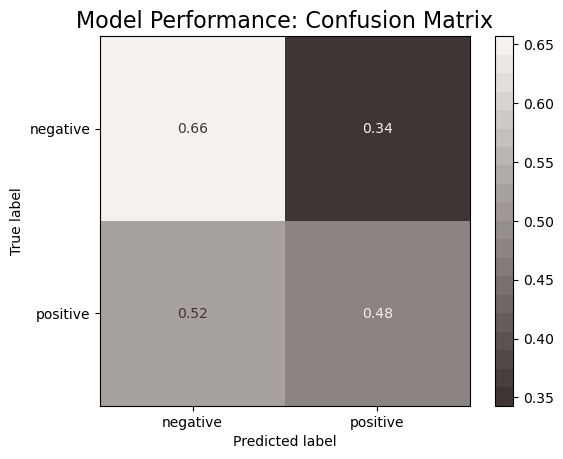

In [133]:
# Calling the confusion matrix function
nostop_cfn_matrix = confusion_matrix_display(pipeline_nostop, y_test, nostop_y_pred)

### <u>5th iteration</u>: Applying the full preprocessing to tweets

    1) Fitting and training train data

In [134]:
# Not applying stopwords to the vectorizer, as they were applied to the preprocessed tweets.

In [135]:
# Defining the pipeline steps 
tfidf_vectorizer = TfidfVectorizer(max_features=10)
naive_bayes_classifier = MultinomialNB()

# Instantiating the pipeline with the undersampler and the new vectorizer
pipeline_prep = imblearn.pipeline.Pipeline([
    ('tfidf', tfidf_vectorizer),
    ('us', RandomUnderSampler(random_state=42)),
    ('classifier', naive_bayes_classifier)
])

# Fitting the pipeline on X_train['tokenized tweet'] which contains the preprocessed tweets
pipeline_prep.fit(X_train['tokenized_tweet'], y_train)

# Generating predictions
prep_y_pred = pipeline_prep.predict(X_test['tokenized_tweet'])

    2) Evaluation Metrics

In [136]:
preprocessed_model_name = 'Preprocessed'

# Calling the function and recording into the defined values
accuracy_pp, f1_pp, precision_pp, cv_pp = evaluation_metrics(
    y_test, 
    prep_y_pred, 
    pipeline_prep, 
    X_train['tokenized_tweet'], 
    y_train)

Accuracy: 0.5767
F1-Score: 0.5887
Precision: 0.6160
Mean Cross-Validated Accuracy: 0.5888


The accuracy score increased slightly, but precision decreased. F1 increased but Cross Validated Accuracy decreased. 

    3) Classification Report

In [137]:
# Drawing the classification report 
prep_class_report = class_calculation(y_test, prep_y_pred)

Classification Report:
               precision    recall  f1-score   support

    negative    0.72474   0.59738   0.65492      1525
    positive    0.39268   0.53432   0.45268       743

    accuracy                        0.57672      2268
   macro avg    0.55871   0.56585   0.55380      2268
weighted avg    0.61596   0.57672   0.58867      2268



    4) Confusion Matrix

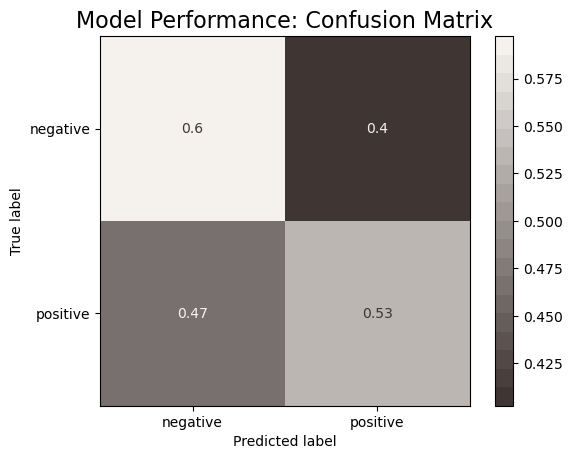

In [138]:
# Plotting the confusion matrix
prep_cnf_matrix = confusion_matrix_display(pipeline_prep, y_test, prep_y_pred)

### <u>6th iteration</u>: Tuning Tfidf Vectorizer - Hyperparameter tuning

    1) Fitting and training train data

In [139]:
from sklearn.model_selection import GridSearchCV

# Defining the pipeline steps, excluding any manual input of features, with the vectorizer and classifier
# The pipeline still includes the undersampler to ensure class imbalance
gs_pipeline = imblearn.pipeline.Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('us', RandomUnderSampler(random_state=42)),
    ('classifier', MultinomialNB())
])

# Define the parameter grid to search over
parameters = {
    'tfidf__max_features': [10, 50, 100, None],
    'tfidf__max_df': [0.7, 0.8, 0.9],
    'tfidf__min_df': [1, 2, 3],
    'tfidf__sublinear_tf': [True, False],
    'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2)],
    # including the list of stopwords that was defined earlier 
    'tfidf__stop_words': [None, 'english', stopwords_list],
}


In [140]:
# Performing grid search for hyperparameter tuning
grid_search = GridSearchCV(gs_pipeline, parameters, cv=5, scoring='accuracy', error_score='raise')

# Fitting the tuned pipeline on training data
grid_search.fit(X_train['tweet_original'], y_train)


GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('us',
                                        RandomUnderSampler(random_state=42)),
                                       ('classifier', MultinomialNB())]),
             param_grid={'tfidf__max_df': [0.7, 0.8, 0.9],
                         'tfidf__max_features': [10, 50, 100, None],
                         'tfidf__min_df': [1, 2, 3],
                         'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'tfidf__stop_words': [None, 'english',
                                               ['i', 'me', 'my', 'myself', 'we',
                                                'our', 'ours', 'ourselves',
                                                'you', "you're", "you've",
                                                "you'll", "you'd", 'your',
                                                'yours', 'yourself',
                                                'yourselves', 'he', 'him',
                                                'his', 'himself', 'she',
                                                "she's", 'her', 'hers',
                                                'herself', 'it', "it's", 'its',
                                                'itself', ...]],
                         'tfidf__sublinear_tf': [True, False]},
             scoring='accuracy')

In [141]:
# Recording the best parameters and printing them
best_tfidf_params = grid_search.best_params_

# Recording the best estimator as the best_pipeline
best_pipeline = grid_search.best_estimator_

print("Best Parameters:", best_tfidf_params)


Best Parameters: {'tfidf__max_df': 0.7, 'tfidf__max_features': None, 'tfidf__min_df': 1, 'tfidf__ngram_range': (2, 2), 'tfidf__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'ho

In [142]:
# Fitting the best pipeline on training data
best_pipeline.fit(X_train['tweet_original'], y_train)

# Fitting the best model on the full training data
best_gs_y_pred = best_pipeline.predict(X_test['tweet_original'])

    2) Evaluation Metrics

In [143]:
# Naming the model
tuned_model_name = 'Tuned NB'

# Calling the function and recording into the defined values
accuracy_gs, f1_gs, precision_gs, cv_gs = evaluation_metrics(
    y_test, 
    best_gs_y_pred, 
    best_pipeline, 
    X_train['tweet_original'], 
    y_train)

Accuracy: 0.6631
F1-Score: 0.6711
Precision: 0.6886
Mean Cross-Validated Accuracy: 0.6491


The classification metrics are starting to increase and are starting to show more stability, less disparity among one another.

    3) Classification Report

In [144]:
# Calling the classification report function
tuned_class_report = class_calculation(y_test, best_gs_y_pred)

Classification Report:
               precision    recall  f1-score   support

    negative    0.78588   0.68590   0.73249      1525
    positive    0.48879   0.61642   0.54524       743

    accuracy                        0.66314      2268
   macro avg    0.63733   0.65116   0.63887      2268
weighted avg    0.68855   0.66314   0.67115      2268



    4) Confusion Matrix

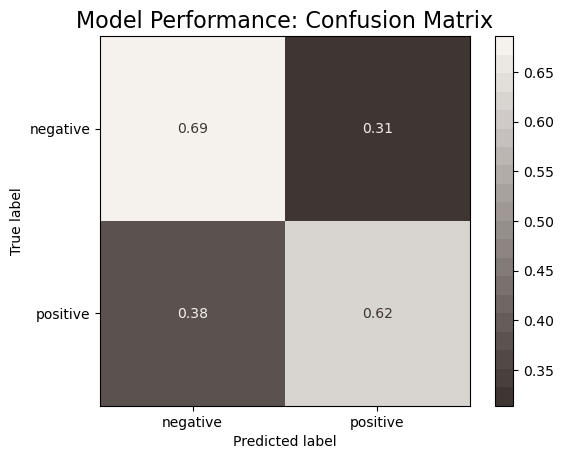

In [145]:
# Plotting the confusion matrix
gs_cfn_matrix = confusion_matrix_display(best_pipeline, y_test, best_gs_y_pred)

### <u>7th iteration</u>: Decision Tree Tfidf Vectorizer

    1) Fitting and training train data

Allowing the best parameters to be used 

Let's see if, by using the best TFIDF parameters with another classifier, we can improve further these predictions.

In [146]:
print(best_tfidf_params)

{'tfidf__max_df': 0.7, 'tfidf__max_features': None, 'tfidf__min_df': 1, 'tfidf__ngram_range': (2, 2), 'tfidf__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any',

In [147]:
def transform_params(best_params):    
    new_best_params = {}
    for key, value in best_params.items():
        # Removing 'tfidf__' from the key
        new_key = key.replace('tfidf__', '')
        new_best_params[new_key] = value
    return new_best_params


In [148]:
new_best_tfidf_params = transform_params(best_tfidf_params)
print(new_best_tfidf_params)

{'max_df': 0.7, 'max_features': None, 'min_df': 1, 'ngram_range': (2, 2), 'stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'mo

In [149]:
# Importing the relevant packages
from sklearn.tree import DecisionTreeClassifier

# Defining the pipeline with new classifier, but the same best parameters
dt_pipeline = imblearn.pipeline.Pipeline([
    ('tfidf', TfidfVectorizer(**new_best_tfidf_params)),
    ('us', RandomUnderSampler(random_state=42)),
    ('classifier', DecisionTreeClassifier())
])

# Fitting the pipeline on training data
dt_pipeline.fit(X_train['tweet_original'], y_train)

# Making predictions on test data
dt_y_pred = dt_pipeline.predict(X_test['tweet_original'])

    2) Evaluation Metrics

In [150]:
# Naming the model
dt_model_name = 'DecisionTree'


# Calling the function and recording into the defined values
accuracy_dt, f1_dt, precision_dt, cv_dt = evaluation_metrics(
    y_test,
    dt_y_pred,
    dt_pipeline,
    X_train['tweet_original'],
    y_train)
    

Accuracy: 0.6684
F1-Score: 0.6651
Precision: 0.6624
Mean Cross-Validated Accuracy: 0.6645


All scores slightly increased and remain consistent.

    3) Classification Report

In [151]:
# Calling the classification report function
class_report_dt = class_calculation(y_test, dt_y_pred)

Classification Report:
               precision    recall  f1-score   support

    negative    0.74478   0.77115   0.75773      1525
    positive    0.49347   0.45760   0.47486       743

    accuracy                        0.66843      2268
   macro avg    0.61912   0.61438   0.61630      2268
weighted avg    0.66245   0.66843   0.66506      2268



Precision for positive tweets is now above 50%.

    4) Confusion Matrix

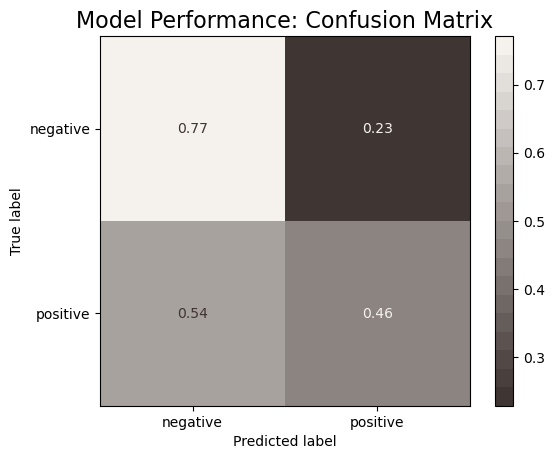

In [152]:
dt_cfn_matrix = confusion_matrix_display(dt_pipeline, y_test, dt_y_pred)

### <u>8th iteration</u>: RandomForestClassifierTuning Tfidf Vectorizer

    1) Fitting and training train data

Let's see if, by using the best TFIDF parameters with another classifier, we can improve further these predictions.

In [153]:
from sklearn.ensemble import RandomForestClassifier

# Defining the pipeline with the fixed tfidf parameters and RandomForestClassifier
rf_pipeline = imblearn.pipeline.Pipeline([
    ('tfidf', TfidfVectorizer(**new_best_tfidf_params)),
    ('us', RandomUnderSampler(random_state=42)),
    ('classifier', RandomForestClassifier())
])

# Fitting the pipeline on training data
rf_pipeline.fit(X_train['tweet_original'], y_train)

# Making predictions on test data
rf_y_pred = rf_pipeline.predict(X_test['tweet_original'])

    2) Evaluation Metrics

In [154]:
# Naming the model and calling the function to evaluate it
rf_tuned_model_name = 'RandomForest'


# Calling the function and recording into the defined values
accuracy_rf, f1_rf, precision_rf, cv_rf = evaluation_metrics(
    y_test,
    rf_y_pred,
    rf_pipeline,
    X_train['tweet_original'],
    y_train
)

Accuracy: 0.6997
F1-Score: 0.6893
Precision: 0.6860
Mean Cross-Validated Accuracy: 0.6924


The accuracy score drastically decreased, but we now have a precision and f1 scores, indicating the 'positive sentiments' are now correctly represented.  

    3) Classification Report

In [155]:
# Calling the function
rf_class_report = class_calculation(y_test, rf_y_pred)

Classification Report:
               precision    recall  f1-score   support

    negative    0.75089   0.82820   0.78765      1525
    positive    0.55290   0.43607   0.48758       743

    accuracy                        0.69974      2268
   macro avg    0.65190   0.63213   0.63762      2268
weighted avg    0.68603   0.69974   0.68935      2268



    4) Confusion Matrix

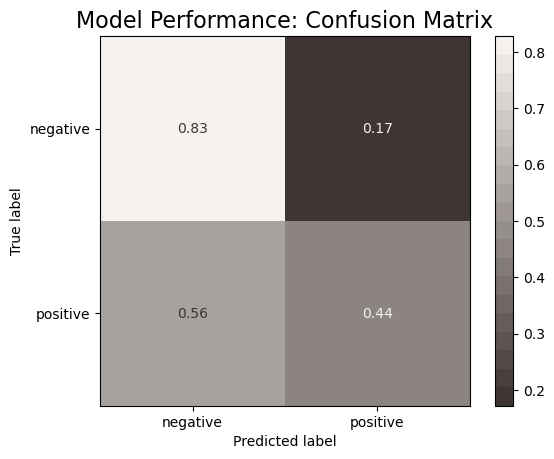

In [156]:
rf_confusion_matrix = confusion_matrix_display(rf_pipeline, y_test, rf_y_pred)

### <u>9th iteration</u>: K-Nearest Neighbor Tfidf Vectorizer

    1) Fitting and training train data

Let's see if, by using the best TFIDF parameters with another classifier, we can improve further these predictions.

In [157]:
from sklearn.neighbors import KNeighborsClassifier

# Defining the pipeline with the fixed tfidf parameters and RandomForestClassifier
knn_pipeline = imblearn.pipeline.Pipeline([
    ('tfidf', TfidfVectorizer(**new_best_tfidf_params)),
    ('us', RandomUnderSampler(random_state=42)),
    ('classifier', KNeighborsClassifier())
])

# Fitting the pipeline on training data
knn_pipeline.fit(X_train['tweet_original'], y_train)

# Making predictions on test data
knn_y_pred = knn_pipeline.predict(X_test['tweet_original'])

    2) Evaluation Metrics

In [158]:
# Naming the model and calling the function to evaluate it
knn_tuned_model_name = 'kNN'


# Calling the function and recording into the defined values
accuracy_knn, precision_knn, f1_knn, cv_knn = evaluation_metrics(
    y_test,
    knn_y_pred,
    knn_pipeline,
    X_train['tweet_original'],
    y_train
)


Accuracy: 0.6839
F1-Score: 0.5890
Precision: 0.6703
Mean Cross-Validated Accuracy: 0.6813


All scores slightly decreased. RandomForest remains the highest performing model so far.

    3) Classification Report

In [159]:
# Calling the function
knn_class_report = class_calculation(y_test, knn_y_pred)

Classification Report:
               precision    recall  f1-score   support

    negative    0.68583   0.97770   0.80616      1525
    positive    0.63830   0.08075   0.14337       743

    accuracy                        0.68386      2268
   macro avg    0.66207   0.52923   0.47477      2268
weighted avg    0.67026   0.68386   0.58903      2268



    4) Confusion Matrix

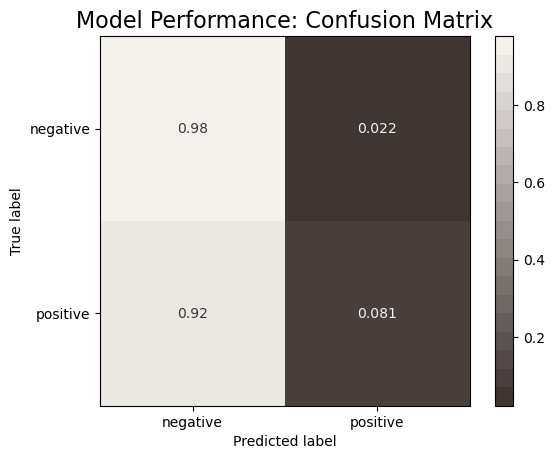

In [160]:
knn_confusion_matrix = confusion_matrix_display(knn_pipeline, y_test, knn_y_pred)

evaluation
<a id='evaluation'></a>

## 6. Evaluation

### 6. a. Final Model and Classification Metrics

In [161]:
# Storing the best model in the associated variable
best_model = rf_pipeline

In [162]:
# Viewing the best parameters defined by Combinatoric Grid Searching 
best_tfidf_params = new_best_tfidf_params
print(list(best_tfidf_params.items())[:])

[('max_df', 0.7), ('max_features', None), ('min_df', 1), ('ngram_range', (2, 2)), ('stop_words', ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'm

    2) Evaluation Metrics

* Train data

In [163]:
# Naming the model and calling the function to evaluate it
best_model_name = 'RandomForest'


# Calling the function and recording into the defined values
accuracy_rf, precision_rf, f1_rf, cv_rf

(0.6997354497354498,
 0.6860297393563699,
 0.6893495203494986,
 0.6924447854086528)

* Test data

In [164]:
# Naming the model and calling the function to evaluate it
best_model_name = 'RandomForest'
# best_pipeline = 

# Calling the function and recording into the defined values
test_accuracy_best, test_precision_best, test_f1_best, test_cv_best = evaluation_metrics(
    y_test,
    rf_y_pred,
    rf_pipeline,
    X_test['tweet_original'],
    y_test
)

Accuracy: 0.6997
F1-Score: 0.6893
Precision: 0.6860
Mean Cross-Validated Accuracy: 0.5982


The model is slightly overfitting, which suggests that the model may be capturing noise in the training data that doesn't generalize well to unseen data. This might be due to undersampling of negative tweets. In a further modelling process, two options should be considered:
1. Stratified Undersampling
<br>Stratified undersampling may protect from the importance given to single words, by keeping the ratio of words or token
2. Synthetic Minority Oversampling
<br> In addition to undersampling tweets to a certain level, positive tweets should be synthetically oversampled as well to try to draw better results. 

    3) Classification Report

In [165]:
# Calling the function
rf_class_report = class_calculation(y_test, rf_y_pred)

Classification Report:
               precision    recall  f1-score   support

    negative    0.75089   0.82820   0.78765      1525
    positive    0.55290   0.43607   0.48758       743

    accuracy                        0.69974      2268
   macro avg    0.65190   0.63213   0.63762      2268
weighted avg    0.68603   0.69974   0.68935      2268



    4) Confusion Matrix

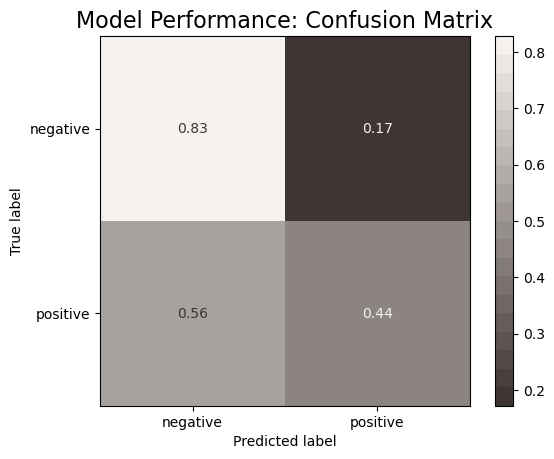

In [166]:
rf_confusion_matrix = confusion_matrix_display(rf_pipeline, y_test, rf_y_pred)

In [167]:
# Storing all models metrics into corresponding lists 
models = [baseline_model_name, resampled_model_name, nostop_model_name, preprocessed_model_name, tuned_model_name, dt_model_name, rf_tuned_model_name, knn_tuned_model_name] 
accuracy_metrics = [accuracy_base, accuracy_rs, accuracy_nostop, accuracy_pp, accuracy_gs, accuracy_dt, accuracy_rf, accuracy_knn]
precision_metrics = [precision_base, precision_rs, precision_nostop, precision_pp, precision_gs, precision_dt, precision_rf, precision_knn]
f1_metrics = [f1_base,  f1_rs, f1_nostop, f1_pp, f1_gs, f1_dt, f1_rf, f1_knn]
cv_metrics = [cv_base, cv_rs, cv_nostop, cv_pp, cv_gs, cv_dt, cv_rf, cv_knn]


In [168]:
# Verifying that all lists have the same size
# print(len(models))
# print()
# print(len(accuracy_metrics))
# print()
# print(len(precision_metrics))
# print()
# print(len(f1_metrics))
# print()
# print(len(cv_metrics))
# print()

In [169]:
# Creating a DataFrame with stored best scores 
models = models

data = {
    'Model': models,
    'Accuracy': accuracy_metrics,
    'F1': f1_metrics,
    'Precision': precision_metrics,
    'Cross-val accuracy': cv_metrics
}

overall = pd.DataFrame(data)

In [170]:
# Inspecting the newly created dataframe
overall

,Model,Accuracy,F1,Precision,Cross-val accuracy
0,Baseline,0.672399,0.452120,0.540684,0.672596
1,Resampled,0.569224,0.580552,0.603026,0.570564
2,No Stopwords,0.599206,0.606697,0.618308,0.603642
3,Preprocessed,0.576720,0.588669,0.615958,0.588793
4,Tuned NB,0.663139,0.671148,0.688551,0.649078
5,DecisionTree,0.668430,0.665063,0.662447,0.664511
6,RandomForest,0.699735,0.689350,0.686030,0.692445
7,kNN,0.683862,0.670260,0.589031,0.681271


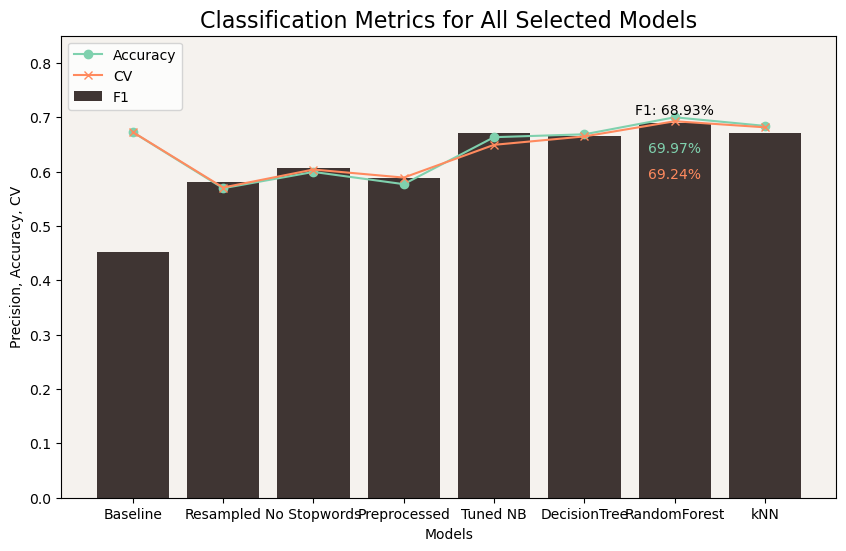

<Figure size 640x480 with 0 Axes>

In [171]:
# Creating a bar chart to review all

#  Creating a bar chart for Precision
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))

# plt.figure(figsize=(10, 6))
plt.bar(overall['Model'], overall['F1'], color='#3F3533', label='F1')

# Creating line plots for Log Loss and Accuracy
plt.plot(overall['Model'], overall['Accuracy'], marker='o', color='#7FD1AE', label='Accuracy')
plt.plot(overall['Model'], overall['Cross-val accuracy'], marker='x', color='#FF8A5E', label='CV')

# Setting labels and title
plt.xlabel('Models')
# plt.ylabel('Precision')
plt.ylabel('Precision, Accuracy, CV')


    
# Annotating the last index of each category
plt.annotate(f'F1: {f1_metrics[6] * 100:.2f}%', (models[6], f1_metrics[6] + 0.01), ha='center', va='bottom')
plt.annotate(f'{accuracy_metrics[6] * 100:.2f}%', (models[6], overall['Accuracy'][6] - 0.07), ha='center', va='bottom', color='#7FD1AE')
plt.annotate(f'{cv_metrics[6] * 100:.2f}%', (models[6], overall['Cross-val accuracy'][6] - 0.11), ha='center', va='bottom', color='#FF8A5E')


    
# Defining the max value of y 
max_y = max(overall[['F1', 'Accuracy']].max())
plt.ylim(0, max_y  + 0.15)
plt.title('Classification Metrics for All Selected Models', fontsize=16)

# Displaying the legend
plt.legend(loc='upper left')

ax.set_facecolor('#F5F2EE')
# Saving the plot as a PNG with a transparent background
# plt.savefig('images/final_model.png')


plt.figure().patch.set_facecolor('#F5F2EE')

# Showing the plot
plt.tight_layout()
plt.show()

<u>Only the top 3 models</u>

In [172]:
top_3_models = overall[overall['F1'] > 0.65]

In [173]:
top_3_models

,Model,Accuracy,F1,Precision,Cross-val accuracy
4,Tuned NB,0.663139,0.671148,0.688551,0.649078
5,DecisionTree,0.668430,0.665063,0.662447,0.664511
6,RandomForest,0.699735,0.689350,0.686030,0.692445
7,kNN,0.683862,0.670260,0.589031,0.681271


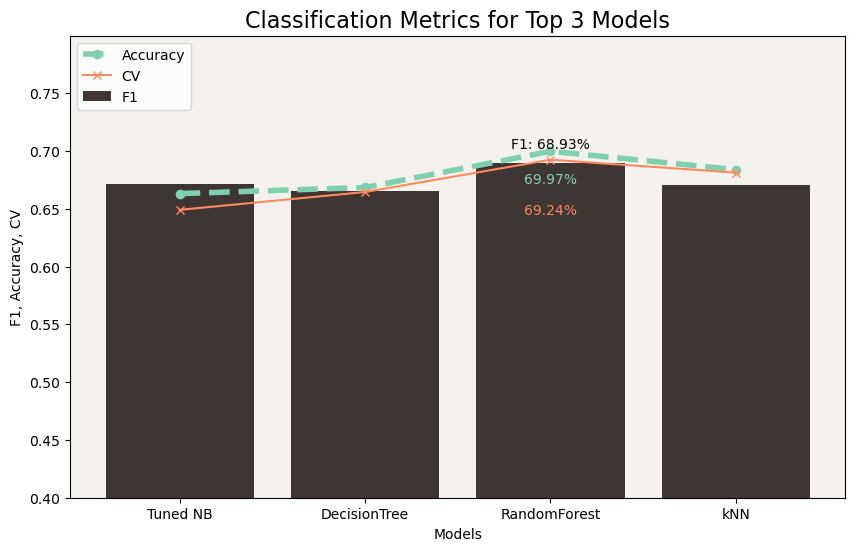

<Figure size 640x480 with 0 Axes>

In [174]:
# Creating a bar chart to review all

#  Creating a bar chart for F1
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))

# plt.figure(figsize=(10, 6))
plt.bar(top_3_models['Model'], top_3_models['F1'], color='#3F3533', label='F1')

# Creating line plots for Log Loss aand Accuracy
plt.plot(top_3_models['Model'], top_3_models['Accuracy'], marker='o', color='#7FD1AE', label='Accuracy', linewidth=4, linestyle='--')
plt.plot(top_3_models['Model'], top_3_models['Cross-val accuracy'], marker='x', color='#FF8A5E', label='CV')

# Setting labels and title
plt.xlabel('Models')
# plt.ylabel('F1')
plt.ylabel('F1, Accuracy, CV')
    
# Annotating the last index of each category
plt.annotate(f'F1: {f1_metrics[6] * 100:.2f}%', (models[6], f1_metrics[6] + 0.01), ha='center', va='bottom')
plt.annotate(f'{accuracy_metrics[6] * 100:.2f}%', (models[6], top_3_models['Accuracy'][6] - 0.03), ha='center', va='bottom', color='#7FD1AE')
plt.annotate(f'{cv_metrics[6] * 100:.2f}%', (models[6], top_3_models['Cross-val accuracy'][6] - 0.05), ha='center', va='bottom', color='#FF8A5E')


    
# Defining the max value of y 
max_y = max(top_3_models[['F1', 'Accuracy']].max())
plt.ylim(0.4, max_y  + 0.1)
plt.title('Classification Metrics for Top 3 Models', fontsize=16)

# Displaying the legend
plt.legend(loc='upper left')

ax.set_facecolor('#F5F2EE')
# Saving the plot as a PNG with a transparent background


plt.figure().patch.set_facecolor('#F5F2EE')

# Saving picture
plt.savefig('images/final_model.png')


# Showing the plot
plt.tight_layout()
plt.show()

**Evaluation of Positive Tweets about Technology Brands at South by Southwest**:

The best model for predicting positive tweets about the best technology brands at South by Southwest was determined to be the Tfidf Vectorizer in conjunction with a Random Forest classifier. The hyperparameters for the Tfidf Vectorizer were fine-tuned using Combinatoric Gridsearch. The chosen model yielded the following impressive metrics:


<br><br>These metrics showcase the robust performance of the model, particularly in terms of precision and accuracy, indicating its ability to effectively identify positive sentiments related to technology brands during the South by Southwest event.

findings_n_recommendations
<a id='findings_n_recommendations'></a>

## 7. Findings & Recommendations

### 7. a) Model Performance

### 7. a) Most Important Features

In [175]:
# Defining a colormap specifically for the top features bar graph
custom_colors = ['#F5F2EE','#B3A6A4', '#8A7E7C', '#635856', '#3F3533']

n_bins = 200

# Creating the custom colormap
features_cmap = LinearSegmentedColormap.from_list("custom_cmap", custom_colors, N=n_bins)

<Figure size 640x480 with 0 Axes>

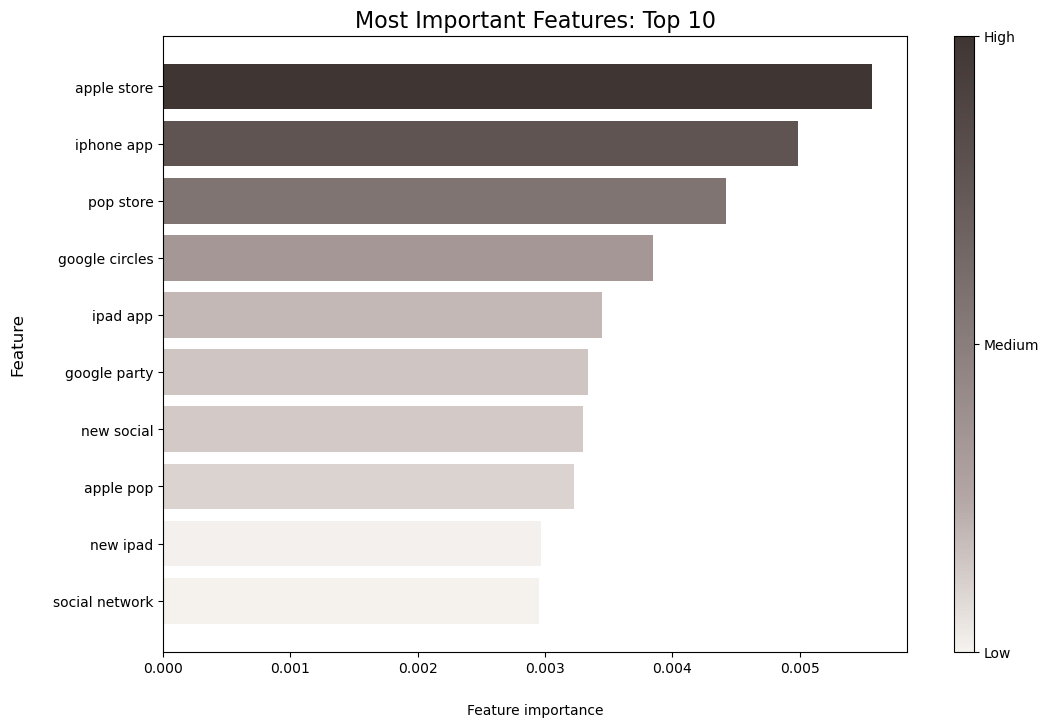

In [202]:
# Importing relevant packages
from matplotlib.cm import ScalarMappable


# Visualizing feature importances with automatically determined colors and sorted in descending order
def plot_top_feature_importances(pipeline, top_n):
    # Accessinf the classifier instance from the pipeline
    classifier = pipeline.named_steps['classifier']
    
    # Getting the feature names from the vectorizer
    feature_names = pipeline.named_steps['tfidf'].get_feature_names_out()

    # Getting the feature importances
    feature_importances = classifier.feature_importances_

    # Sorting feature importances in descending order and get the corresponding indices
    sorted_indices = np.argsort(feature_importances)[::-1]

    # Selecting the top 'top_n' features
    top_indices = sorted_indices[:top_n]

    # Sorting the feature names based on the selected top indices
    top_feature_names = feature_names[top_indices]

    # Sorting the feature importances for the selected top features
    top_feature_importances = feature_importances[top_indices]

    # Reverse the order to make it descending
    top_feature_names = top_feature_names[::-1]
    top_feature_importances = top_feature_importances[::-1]
    

    # Creating a colormap
    cmap = plt.get_cmap(features_cmap)

    # Manually normalizing importance values
    normalized_importances = (top_feature_importances - np.min(top_feature_importances)) / (np.max(top_feature_importances) - np.min(top_feature_importances))

    # Creating the figure and axis
    fig, ax = plt.subplots(figsize=(12, 8))

    # Using normalized_importances directly for color mapping
    bars = ax.barh(range(top_n), top_feature_importances, align='center', color=cmap(normalized_importances))
    plt.yticks(range(top_n), top_feature_names)
    plt.xlabel('Feature importance', labelpad=20)
    plt.ylabel('Feature', fontsize=12, labelpad=20)
    plt.title('Most Important Features: Top {}'.format(top_n), fontsize=16)

    # Adding a colorbar to the right of the plot
    sm = ScalarMappable(cmap=cmap)
    sm.set_array([])
    colorbar = plt.colorbar(sm, ax=ax, orientation='vertical', aspect=30)
    # Hide colorbar ticks
    # Defining custom tick positions
    custom_ticks = [0, 0.5, 1]
    custom_ticklabels = ['Low', 'Medium', 'High']
    colorbar.set_ticks(custom_ticks)
    colorbar.set_ticklabels(custom_ticklabels)
    plt.show()
    return top_feature_names[::-1] 
    
# Saving picture
plt.savefig('images/most_important_features.png')

    
    

# Calling the function with the best model
top_10_features = plot_top_feature_importances(rf_pipeline, top_n=10)

In [196]:
# Inspecting the returned top 10 features 
top_10_features

array(['apple store', 'iphone app', 'pop store', 'google circles',
       'ipad app', 'google party', 'new social', 'apple pop', 'new ipad',
       'social network'], dtype=object)

We will now create X_positive DataFrame. This will allow us to review the tweets for each the top 10 features by importance. 

In [182]:
# Creating  dataframe to glance through the tweets containing the top 10 most important features to validate our recommendations  
X_positive = X_train[y_train == 'positive']

In [239]:
X_positive[X_positive['tweet_original'].str.contains('apple store')].head()

,tweet,product_or_company,tweet_original,tokenized_tweet,label
3689,"[wait, line, apple, store, ipad]",iPad,Wait in line at #SXSW apple store for iPad 2,wait line apple store ipad,positive
1249,"[expecting, see, flood, shiny, new, ipad2, today, line, apple, store, around, block]",iPad,Expecting to see a flood of shiny new ipad2's today @mention Line at apple store was around the block #sxsw,expecting see flood shiny new ipad2 today line apple store around block,positive
4729,"[seeing, ton, ipad2s, around, guess, took, long, get, apple, store, line]",iPad,Seeing tons of iPad2s around. Guess it just took that long to get through the #SXSW apple store line (@mention,seeing ton ipad2s around guess took long get apple store line,positive
4866,"[excited, meet, team, way, apple, store, go, download, app]",iPad or iPhone App,Excited to meet the @mention team on the way to the apple store. Go download their app if you're in #sxsw! {link},excited meet team way apple store go download app,positive
7412,"[apple, store, buying, ipad, guess, geek, drunk, hahaha]",undefined,At the apple store with @mention he's buying an iPad...I guess this is what geeks do when they're drunk hahaha #sxsw,apple store buying ipad guess geek drunk hahaha,positive


In [227]:
# Inspecting the tweets related to top 10 features  
for feature in top_10_features:
    print(feature.upper())
    print()
    print(X_positive[X_positive['tweet_original'].str.contains(feature)][['tweet_original']][:10])

APPLE STORE

                                                                                                                          tweet_original
3689                                                                                        Wait in line at #SXSW apple store for iPad 2
1249                         Expecting to see a flood of shiny new ipad2's today @mention Line at apple store was around the block #sxsw
4729                      Seeing tons of iPad2s around. Guess it just took that long to get through the #SXSW apple store line (@mention
4866                  Excited to meet the @mention team on the way to the apple store. Go download their app if you're in #sxsw!  {link}
7412                At the apple store with @mention he's buying an iPad...I guess this is what geeks do when they're drunk hahaha #sxsw
4910               Speaking of #sxsw: how about that #apple store on 6th and congress? Wouldn't it be great if it were permanent....? ;)
7628           Apple Store i

In [177]:
# Getting the vectorized tweets as an array and transforming it to a list
feature_names_list = rf_pipeline.named_steps['tfidf'].get_feature_names_out().tolist()

# Convert the NumPy array to a Python list
# feature_names_list = feature_names_array

# Concatenate the feature names into a single string
vectorized_tweets = ' '.join(feature_names_list)

In [237]:
X_positive[X_positive['tweet_original'].str.contains(feature)][['tweet_original']]

,tweet_original
6366,RT @mention New social network may debut at #SXSW Google Circles {link} #EatDrinkTweet Not done with you yet!
2451,I'm headed down to #SXSW to hear a talk on integrated social network dynamics and team synergy. I've got my iPad ready to go.
6362,RT @mention New Post: @mention iPhone app makes it easy to connect on all social networks with people you meet {link} #sxsw
6542,"RT @mention RT @mention Google to launch a social network, Circles, at #SxSW - {link} - Who's excited?"
80,New Post: @mention iPhone app makes it easy to connect on all social networks with people you meet {link} #sxsw
752,"Google to launch a social network, Circles, at #SxSW - {link} - Who's excited?"
5858,RT @mention Google set to launch new social network #Circles today at #sxsw
4967,Wow! - Google to launch new social network at SXSW? {link} #sxsw #google
2036,I hope #apple approves iRelay social network for mobile photo sharing app before #SXSW. Easier to share with people of they can download
1302,Wishing I was at #sxsw to see the rumored demo of @mention new social network 'Circles' {link} (via @mention


In [269]:
# Creating an empty DataFrame to store the tweets related to the top features
dfs_to_concat = []

# Iterating through the top features
for feature_name in top_10_features:
    # Filter tweets containing the current top feature
    matching_tweets = X_positive[X_positive['tweet_original'].str.contains(feature_name)]
    
    # Appending matching tweets to the list
    dfs_to_concat.append(matching_tweets)

# Concatenating the list of DataFrames into a single DataFrame
X_positive_top_features = pd.concat(dfs_to_concat, ignore_index=True)

# Print or use X_positive_top_features as needed
X_positive_top_features


,tweet,product_or_company,tweet_original,tokenized_tweet,label
0,"[wait, line, apple, store, ipad]",iPad,Wait in line at #SXSW apple store for iPad 2,wait line apple store ipad,positive
1,"[expecting, see, flood, shiny, new, ipad2, today, line, apple, store, around, block]",iPad,Expecting to see a flood of shiny new ipad2's today @mention Line at apple store was around the block #sxsw,expecting see flood shiny new ipad2 today line apple store around block,positive
2,"[seeing, ton, ipad2s, around, guess, took, long, get, apple, store, line]",iPad,Seeing tons of iPad2s around. Guess it just took that long to get through the #SXSW apple store line (@mention,seeing ton ipad2s around guess took long get apple store line,positive
3,"[excited, meet, team, way, apple, store, go, download, app]",iPad or iPhone App,Excited to meet the @mention team on the way to the apple store. Go download their app if you're in #sxsw! {link},excited meet team way apple store go download app,positive
4,"[apple, store, buying, ipad, guess, geek, drunk, hahaha]",undefined,At the apple store with @mention he's buying an iPad...I guess this is what geeks do when they're drunk hahaha #sxsw,apple store buying ipad guess geek drunk hahaha,positive
...,...,...,...,...,...
96,"[sound, intriguing, lot, chatter, around, google, new, social, network, circle, kek]",Other Google product or service,"Sounds intriguing... RT @mention Lots of chatter around Google's new social network, Circles #SXSW -KEK",sound intriguing lot chatter around google new social network circle kek,positive
97,"[really, need, another, big, social, network, right, thanks, google]",Other Google product or service,We really DO need another big social network right now - thanks! #SXSW #Google {link},really need another big social network right thanks google,positive
98,"[google, denies, launch, major, new, social, network, circle, including, tim, reily, say, exists, awesome]",Other Google product or service,"Google denies it will launch major new social network, Circles, at #sxsw. But some, including Tim O'Reily, say it exists and is, awesome!",google denies launch major new social network circle including tim reily say exists awesome,positive
99,"[google, tipped, launch, social, network, today, called, circle]",undefined,Google tipped to launch social network today at #sxsw called Circles {link},google tipped launch social network today called circle,positive


In [277]:
# Defining list of product or company name to remove
list_of_company_products = ['google', 'android', 'apple', 'ipad', 'iphone', 'ipad2', 'iphone ']

In [278]:
nocomp_positive_top_features = X_positive_top_features.copy()
nocomp_positive_top_features

,tweet,product_or_company,tweet_original,tokenized_tweet,label
0,"[wait, line, apple, store, ipad]",iPad,Wait in line at #SXSW apple store for iPad 2,wait line apple store ipad,positive
1,"[expecting, see, flood, shiny, new, ipad2, today, line, apple, store, around, block]",iPad,Expecting to see a flood of shiny new ipad2's today @mention Line at apple store was around the block #sxsw,expecting see flood shiny new ipad2 today line apple store around block,positive
2,"[seeing, ton, ipad2s, around, guess, took, long, get, apple, store, line]",iPad,Seeing tons of iPad2s around. Guess it just took that long to get through the #SXSW apple store line (@mention,seeing ton ipad2s around guess took long get apple store line,positive
3,"[excited, meet, team, way, apple, store, go, download, app]",iPad or iPhone App,Excited to meet the @mention team on the way to the apple store. Go download their app if you're in #sxsw! {link},excited meet team way apple store go download app,positive
4,"[apple, store, buying, ipad, guess, geek, drunk, hahaha]",undefined,At the apple store with @mention he's buying an iPad...I guess this is what geeks do when they're drunk hahaha #sxsw,apple store buying ipad guess geek drunk hahaha,positive
...,...,...,...,...,...
96,"[sound, intriguing, lot, chatter, around, google, new, social, network, circle, kek]",Other Google product or service,"Sounds intriguing... RT @mention Lots of chatter around Google's new social network, Circles #SXSW -KEK",sound intriguing lot chatter around google new social network circle kek,positive
97,"[really, need, another, big, social, network, right, thanks, google]",Other Google product or service,We really DO need another big social network right now - thanks! #SXSW #Google {link},really need another big social network right thanks google,positive
98,"[google, denies, launch, major, new, social, network, circle, including, tim, reily, say, exists, awesome]",Other Google product or service,"Google denies it will launch major new social network, Circles, at #sxsw. But some, including Tim O'Reily, say it exists and is, awesome!",google denies launch major new social network circle including tim reily say exists awesome,positive
99,"[google, tipped, launch, social, network, today, called, circle]",undefined,Google tipped to launch social network today at #sxsw called Circles {link},google tipped launch social network today called circle,positive


In [279]:
# Removing any word corresponding to product or company
nocomp_positive_top_features['tweet'] = nocomp_positive_top_features['tweet'].apply(
    lambda tweet_list: [word for word in tweet_list if word.lower() not in list_of_company_products]
)

In [280]:
nocomp_positive_top_features

,tweet,product_or_company,tweet_original,tokenized_tweet,label
0,"[wait, line, store]",iPad,Wait in line at #SXSW apple store for iPad 2,wait line apple store ipad,positive
1,"[expecting, see, flood, shiny, new, today, line, store, around, block]",iPad,Expecting to see a flood of shiny new ipad2's today @mention Line at apple store was around the block #sxsw,expecting see flood shiny new ipad2 today line apple store around block,positive
2,"[seeing, ton, ipad2s, around, guess, took, long, get, store, line]",iPad,Seeing tons of iPad2s around. Guess it just took that long to get through the #SXSW apple store line (@mention,seeing ton ipad2s around guess took long get apple store line,positive
3,"[excited, meet, team, way, store, go, download, app]",iPad or iPhone App,Excited to meet the @mention team on the way to the apple store. Go download their app if you're in #sxsw! {link},excited meet team way apple store go download app,positive
4,"[store, buying, guess, geek, drunk, hahaha]",undefined,At the apple store with @mention he's buying an iPad...I guess this is what geeks do when they're drunk hahaha #sxsw,apple store buying ipad guess geek drunk hahaha,positive
...,...,...,...,...,...
96,"[sound, intriguing, lot, chatter, around, new, social, network, circle, kek]",Other Google product or service,"Sounds intriguing... RT @mention Lots of chatter around Google's new social network, Circles #SXSW -KEK",sound intriguing lot chatter around google new social network circle kek,positive
97,"[really, need, another, big, social, network, right, thanks]",Other Google product or service,We really DO need another big social network right now - thanks! #SXSW #Google {link},really need another big social network right thanks google,positive
98,"[denies, launch, major, new, social, network, circle, including, tim, reily, say, exists, awesome]",Other Google product or service,"Google denies it will launch major new social network, Circles, at #sxsw. But some, including Tim O'Reily, say it exists and is, awesome!",google denies launch major new social network circle including tim reily say exists awesome,positive
99,"[tipped, launch, social, network, today, called, circle]",undefined,Google tipped to launch social network today at #sxsw called Circles {link},google tipped launch social network today called circle,positive


In [281]:
# Concatenate all tweets into a single string
top_feature_tweets_nocomp = ' '.join(nocomp_positive_top_features['tweet'].apply(lambda x: ' '.join(map(str, x))))

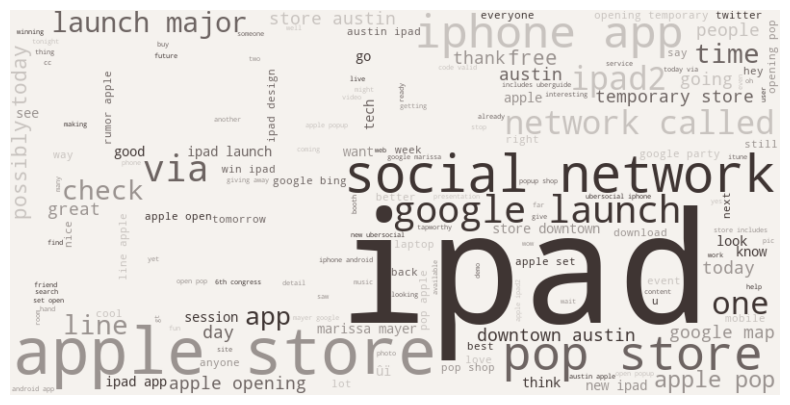

In [282]:
wordcloud_graph(top_feature_tweets_nocomp)

### 7. c) Recommendations

In order to create buzz around the launch of the new folding tablet by Samsung: 
1. Physically sell it at the conference
    * Give early access to SXSW attendees
    * Create pop-up stores in the conference 
    * Buyers will wait in line which creates even more attraction
2. Develop an outstanding phone and tablet app for the conference
    * Facilitate the conference access 
    * Tap into people's creativity for use
3. Create a hashtag to win the tablet
    * The social network was talked about - since then, multiple social networks were created and a 
    
4. Throw a great party
    * Create exclusivity through the app
    * The concert last year was great, try to surpass this!


limits_n_next_steps
<a id='limits_n_next_steps'></a>

## 8. Limits & Next Steps

Accuracy could be improved. 
was not the highest and 

Text Text Text Text Text Text 